In [ ]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
    #tensor = 128 (images) x 784 (=28x28)
    data = tensor.detach().cpu().view(-1, ch, *size) # 128 x 1 x 28 x 28
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # change the order of dimensions: 1 x 28 x 28 = 28 x 28 x 1
    plt.imshow(grid)
    plt.show()

In [ ]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

# hyperparameters
z_dim = 64 # size of the random noise vector
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128 # batch_size
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

# number of steps = 60000 (images) / 128 (batch size) = 468.75 --> 469

100%|██████████| 9912422/9912422 [00:00<00:00, 112774604.50it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 101794700.69it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 186151254.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19012503.76it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
from torch.nn.modules.activation import Sigmoid
# declare our models

# Generator
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim=64, i_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 x 128
            genBlock(h_dim, h_dim*2), # 128 x 256
            genBlock(h_dim*2, h_dim*4), # 256 x 512
            genBlock(h_dim*4, h_dim*8), # 512 x 1024
            nn.Linear(h_dim*8, i_dim), # 1024 x 784 (28x28)
            nn.Sigmoid(), # sets values between 0 and 1
        )

    def forward(self, noise):
        return self.gen(noise)

def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device) # to store on GPU

# Discriminator
def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2)
    )

class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim=256):
        super().__init__()
        self.disc = nn.Sequential(
            discBlock(i_dim, h_dim*4), # 784 x 1024
            discBlock(h_dim*4, h_dim*2), # 1024 x 512
            discBlock(h_dim*2, h_dim), #512 x 256
            nn.Linear(h_dim, 1) # 256 x 1
        )

    def forward(self, image):
        return self.disc(image)

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([0, 0, 4, 6, 9, 3, 0, 4, 0, 2])


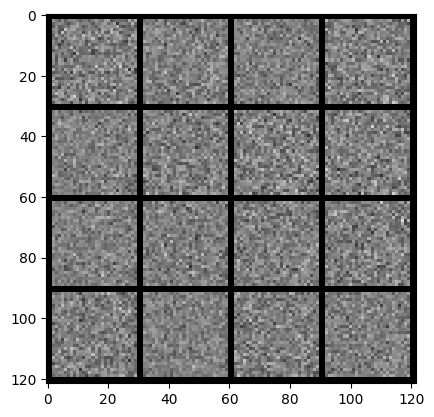

In [ ]:
noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [ ]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)

    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)

    return gen_loss

# discriminator loss
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    noise = gen_noise(number, z_dim)
    fake = gen(noise)

    disc_fake = disc(fake.detach())
    disc_fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, disc_real_targets)

    disc_loss = (disc_fake_loss + disc_real_loss)/2

    return disc_loss

  0%|          | 0/469 [00:00<?, ?it/s]

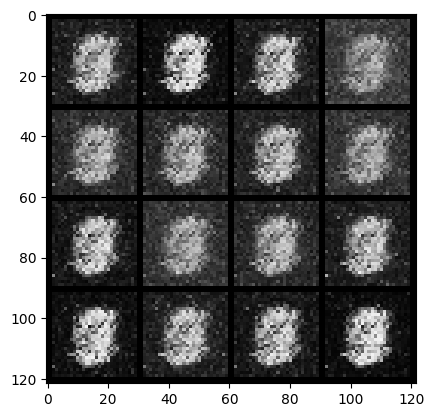

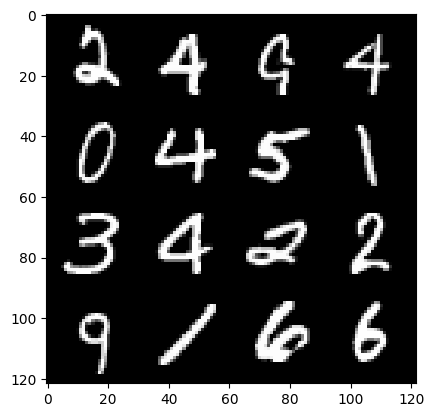

0: step 300 / Gen loss: 1.9211040623982751 / Disc loss: 0.34910651594400427


  0%|          | 0/469 [00:00<?, ?it/s]

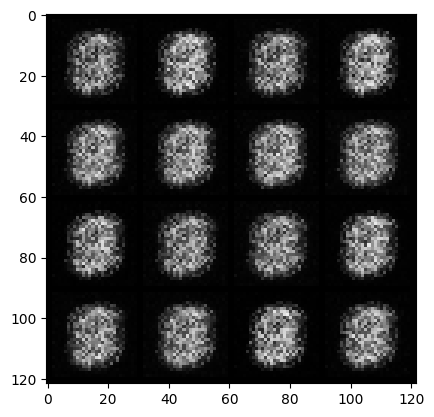

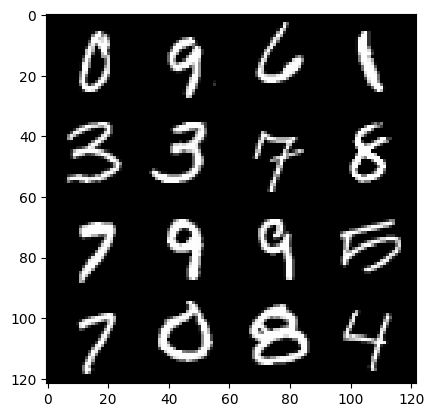

1: step 300 / Gen loss: 5.276628458499908 / Disc loss: 0.16339769879976918


  0%|          | 0/469 [00:00<?, ?it/s]

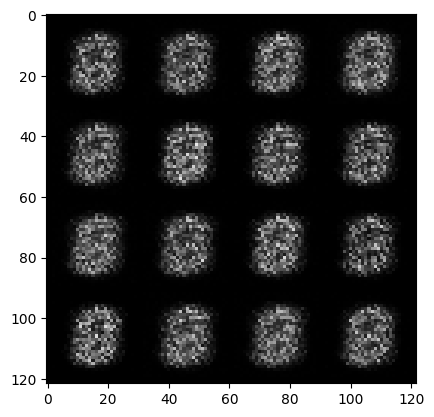

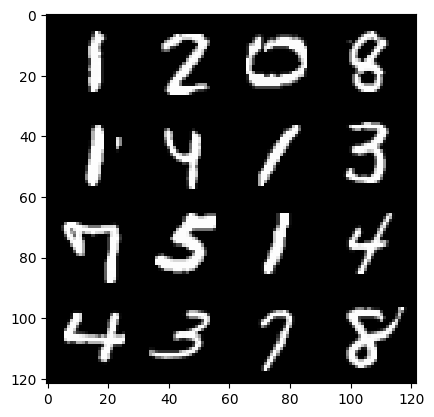

2: step 300 / Gen loss: 5.480479480425521 / Disc loss: 0.06127484031642474


  0%|          | 0/469 [00:00<?, ?it/s]

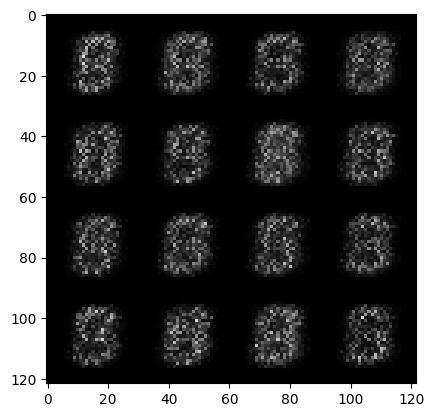

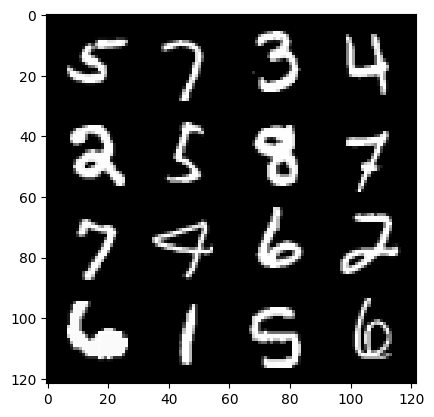

3: step 300 / Gen loss: 5.206774929364526 / Disc loss: 0.07138341989989076


  0%|          | 0/469 [00:00<?, ?it/s]

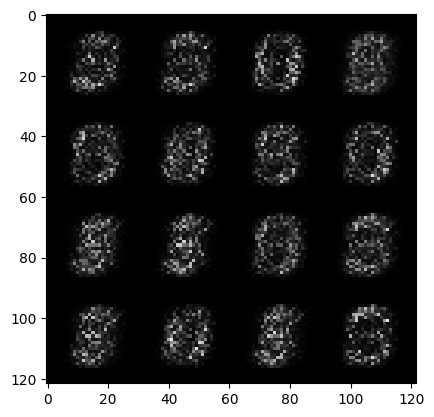

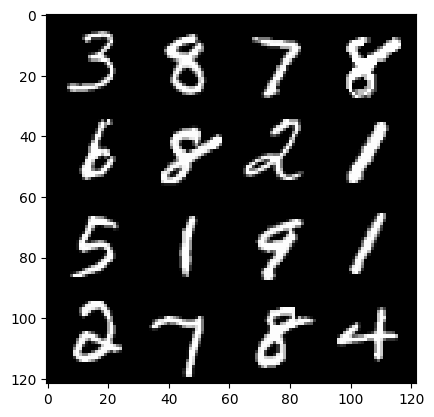

4: step 300 / Gen loss: 5.462172300815577 / Disc loss: 0.07219208364685378


  0%|          | 0/469 [00:00<?, ?it/s]

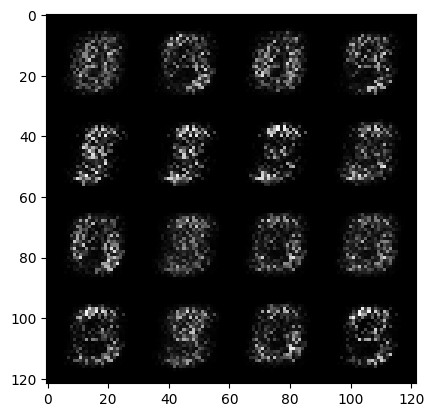

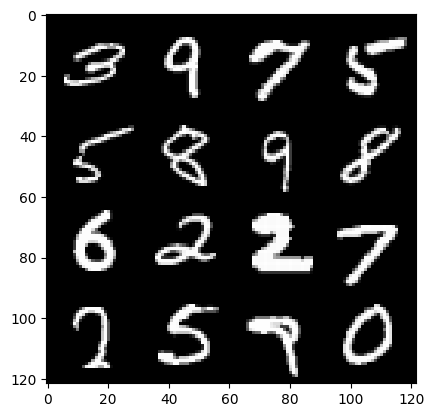

5: step 300 / Gen loss: 6.299521426359811 / Disc loss: 0.05388910348837576


  0%|          | 0/469 [00:00<?, ?it/s]

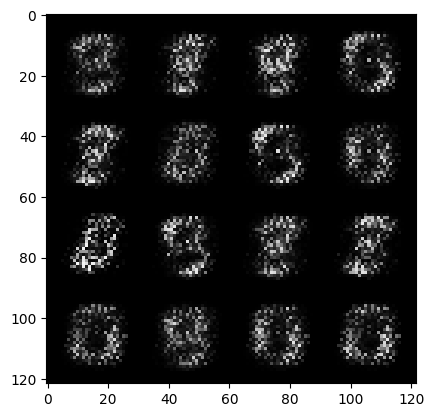

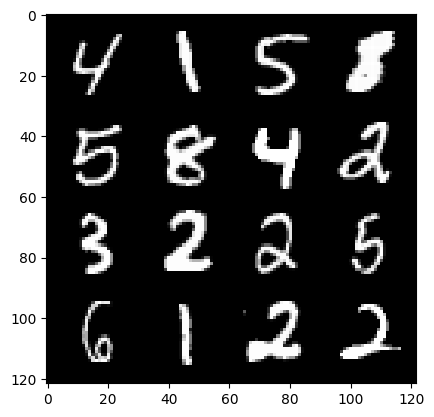

6: step 300 / Gen loss: 7.234238258997597 / Disc loss: 0.040298188334951794


  0%|          | 0/469 [00:00<?, ?it/s]

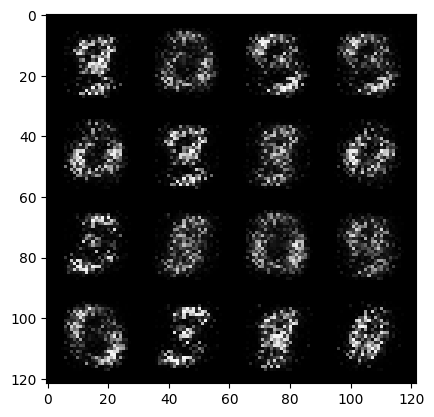

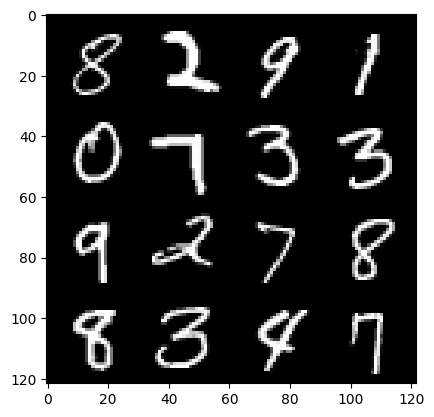

7: step 300 / Gen loss: 7.878625267346697 / Disc loss: 0.03505435542513929


  0%|          | 0/469 [00:00<?, ?it/s]

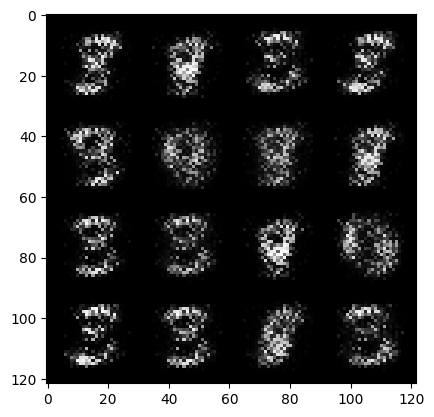

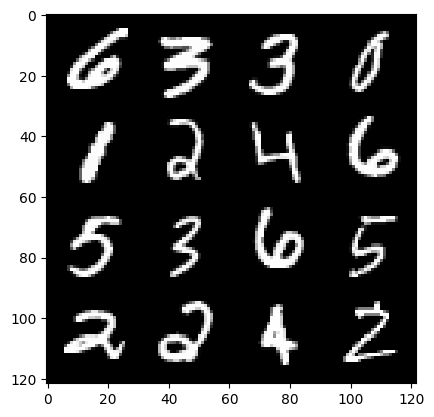

8: step 300 / Gen loss: 8.746390482584639 / Disc loss: 0.036027432074770355


  0%|          | 0/469 [00:00<?, ?it/s]

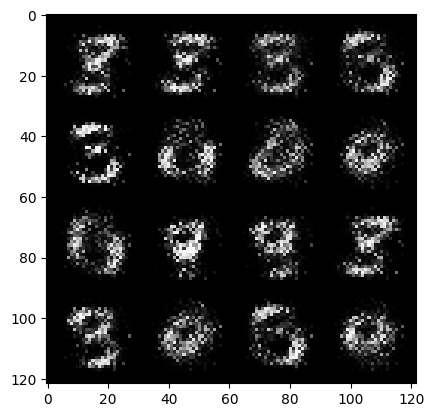

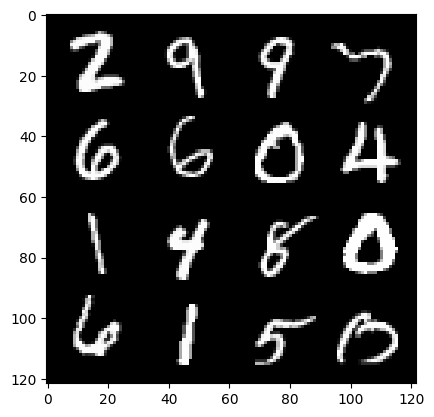

9: step 300 / Gen loss: 8.922352369626369 / Disc loss: 0.032259407620877034


  0%|          | 0/469 [00:00<?, ?it/s]

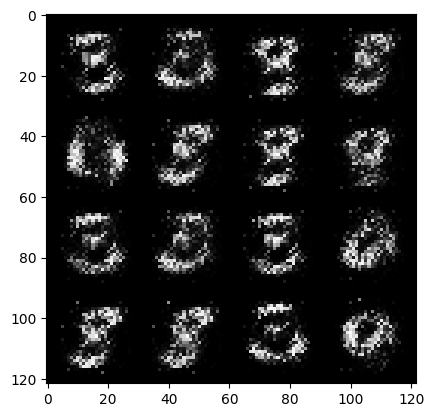

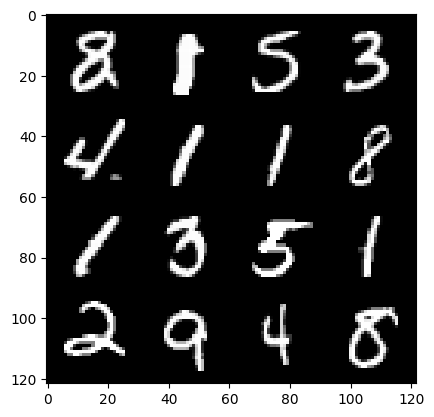

10: step 300 / Gen loss: 9.172882936795547 / Disc loss: 0.0255675403230513


  0%|          | 0/469 [00:00<?, ?it/s]

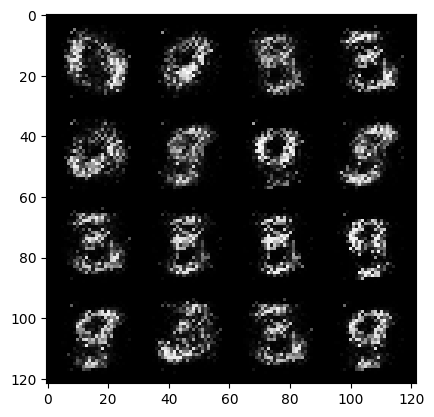

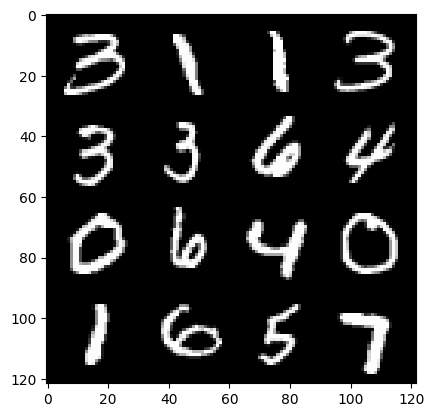

11: step 300 / Gen loss: 9.583897775014238 / Disc loss: 0.020878867399878796


  0%|          | 0/469 [00:00<?, ?it/s]

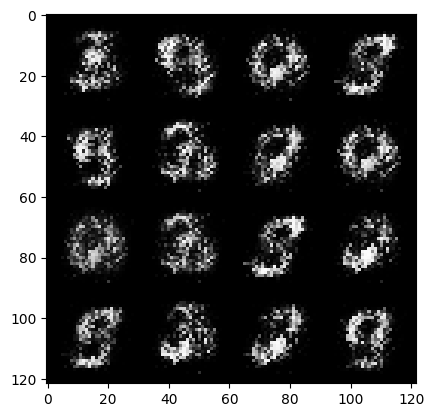

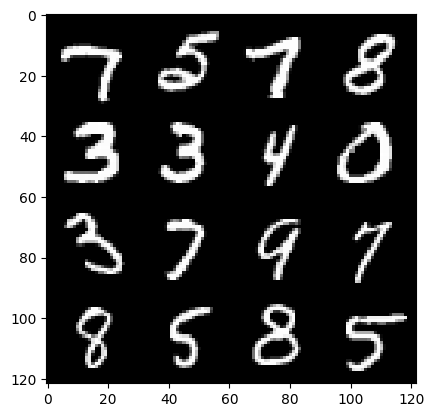

12: step 300 / Gen loss: 9.689258945782976 / Disc loss: 0.019451084452836453


  0%|          | 0/469 [00:00<?, ?it/s]

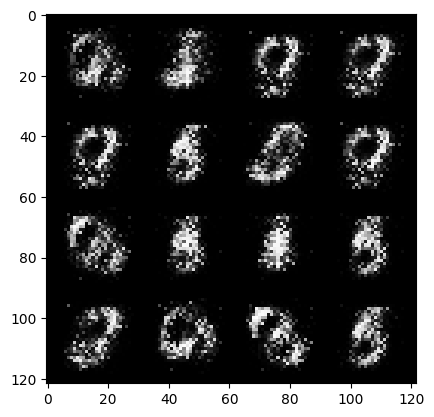

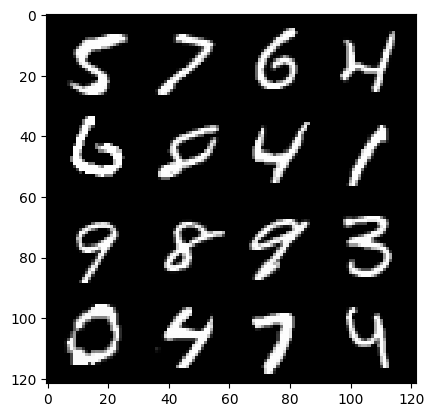

13: step 300 / Gen loss: 10.006410810152685 / Disc loss: 0.02438152176017561


  0%|          | 0/469 [00:00<?, ?it/s]

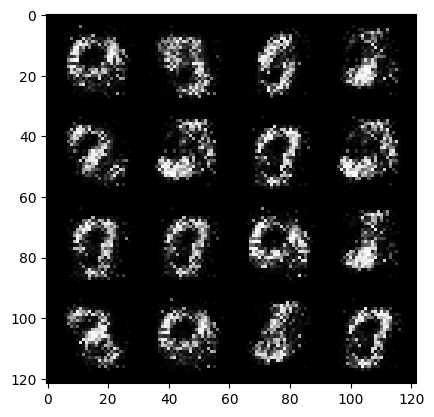

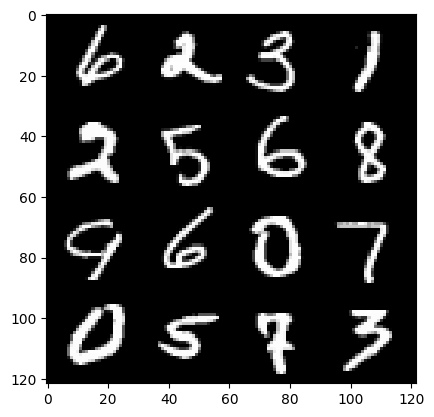

14: step 300 / Gen loss: 9.645396804809572 / Disc loss: 0.02261546750397731


  0%|          | 0/469 [00:00<?, ?it/s]

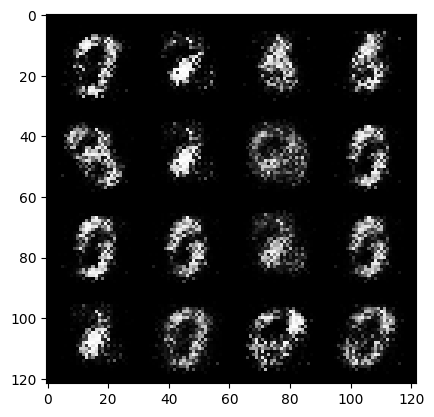

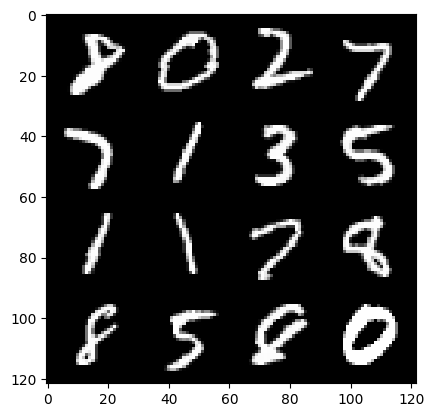

15: step 300 / Gen loss: 9.864923154513049 / Disc loss: 0.016335871336050328


  0%|          | 0/469 [00:00<?, ?it/s]

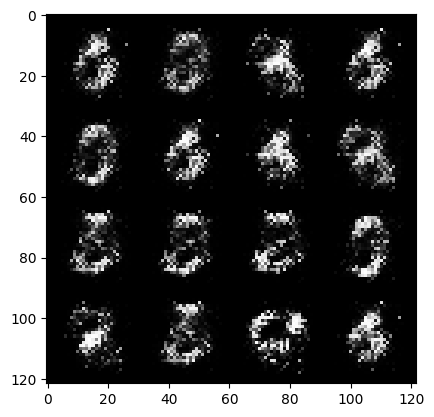

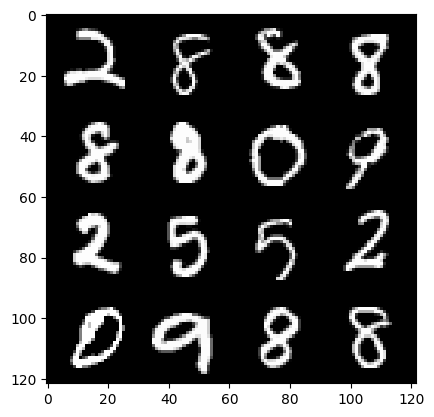

16: step 300 / Gen loss: 10.516554649670919 / Disc loss: 0.01410562710952945


  0%|          | 0/469 [00:00<?, ?it/s]

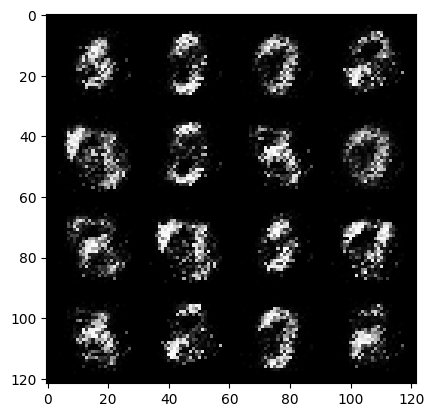

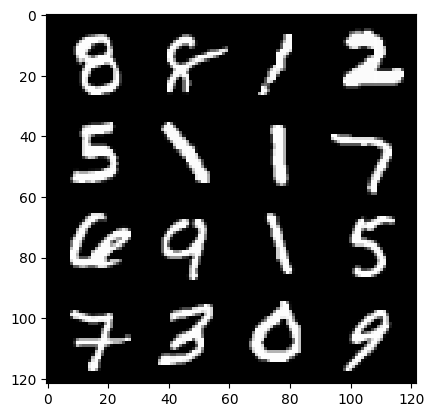

17: step 300 / Gen loss: 11.15371339480083 / Disc loss: 0.01427878867679586


  0%|          | 0/469 [00:00<?, ?it/s]

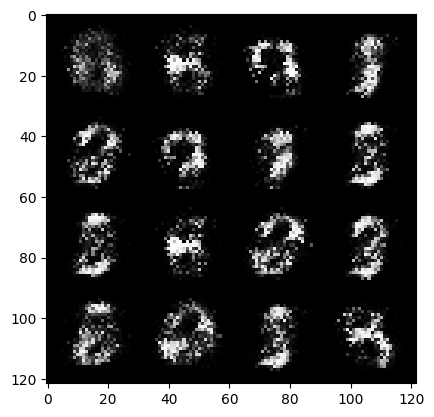

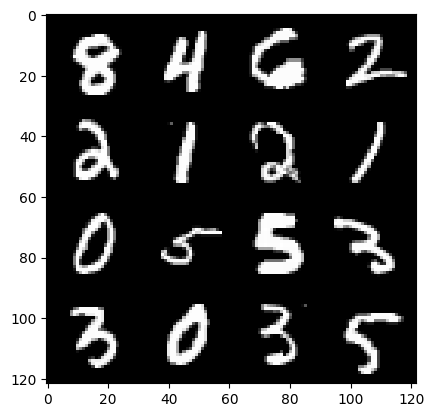

18: step 300 / Gen loss: 10.590027254422512 / Disc loss: 0.019155904245562853


  0%|          | 0/469 [00:00<?, ?it/s]

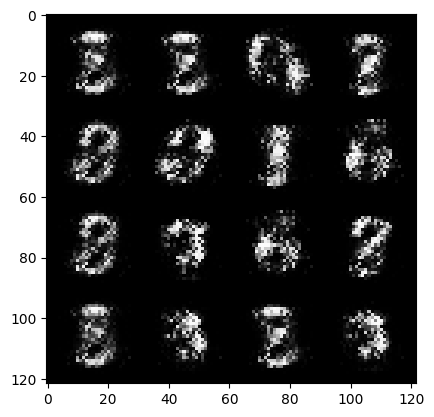

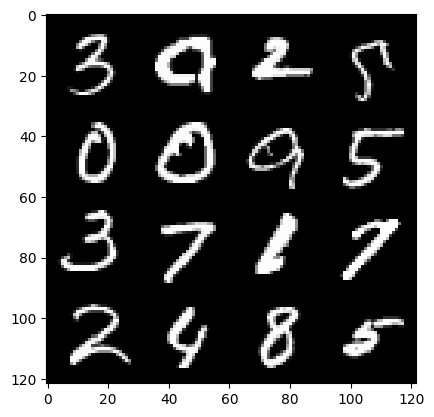

19: step 300 / Gen loss: 10.380472029050194 / Disc loss: 0.019973857672108967


  0%|          | 0/469 [00:00<?, ?it/s]

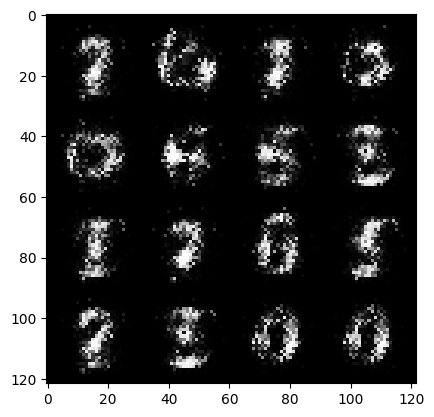

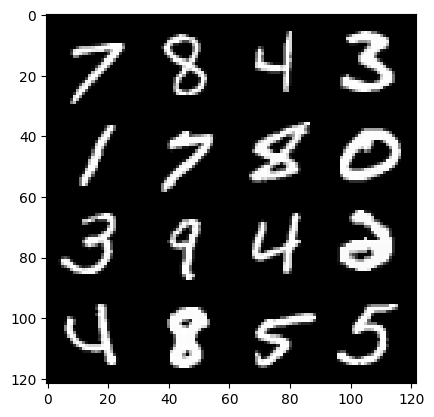

20: step 300 / Gen loss: 11.007780714035038 / Disc loss: 0.01754093415879956


  0%|          | 0/469 [00:00<?, ?it/s]

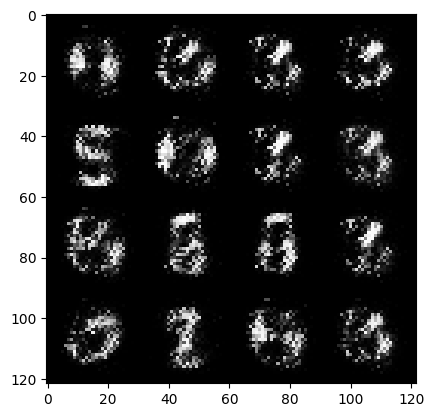

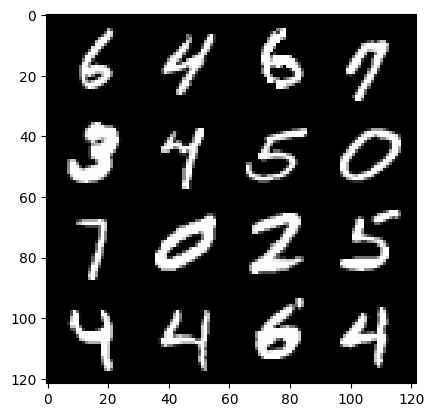

21: step 300 / Gen loss: 11.181081631978351 / Disc loss: 0.01988690021680669


  0%|          | 0/469 [00:00<?, ?it/s]

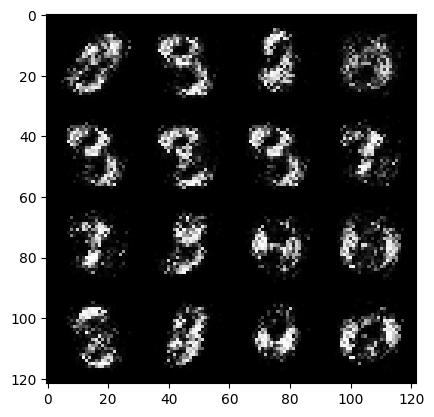

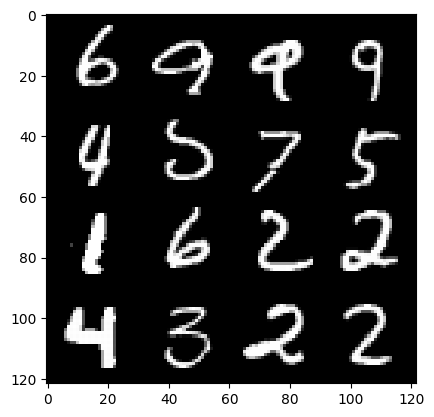

22: step 300 / Gen loss: 10.43401121139526 / Disc loss: 0.02256092234281823


  0%|          | 0/469 [00:00<?, ?it/s]

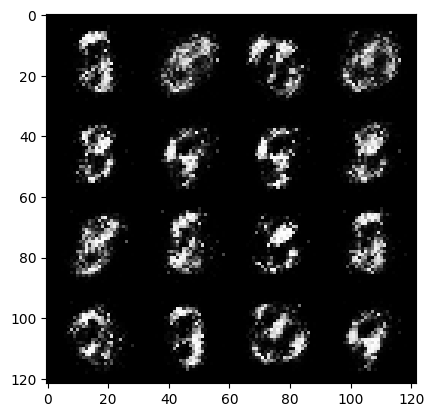

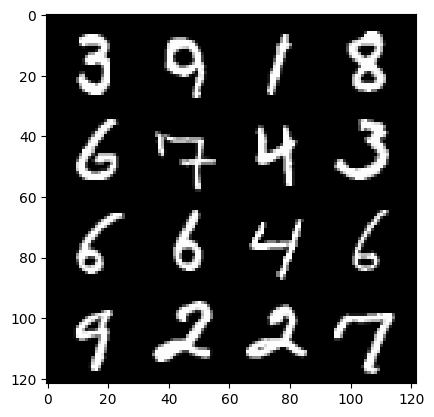

23: step 300 / Gen loss: 10.990896568298352 / Disc loss: 0.026129428291848562


  0%|          | 0/469 [00:00<?, ?it/s]

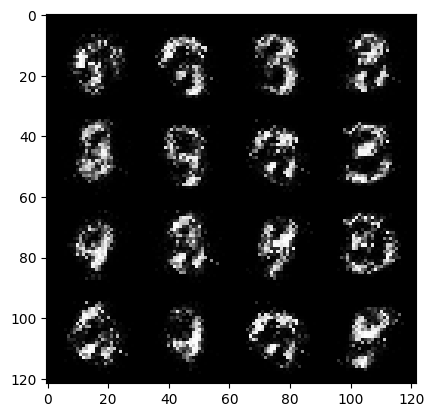

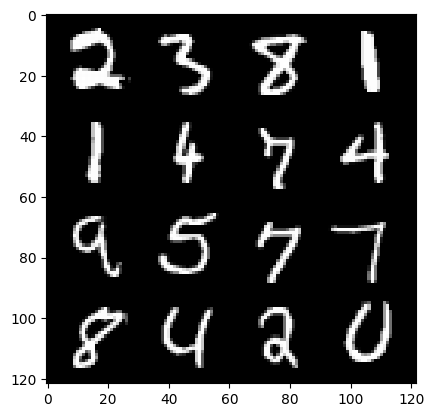

24: step 300 / Gen loss: 10.103619017601007 / Disc loss: 0.025460699509518847


  0%|          | 0/469 [00:00<?, ?it/s]

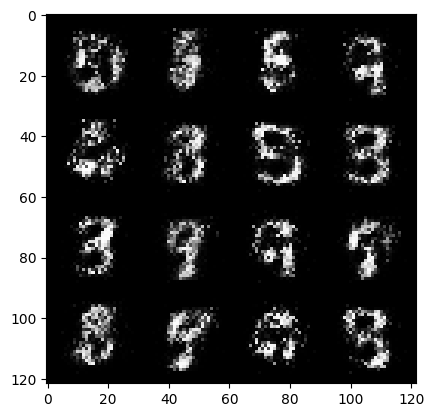

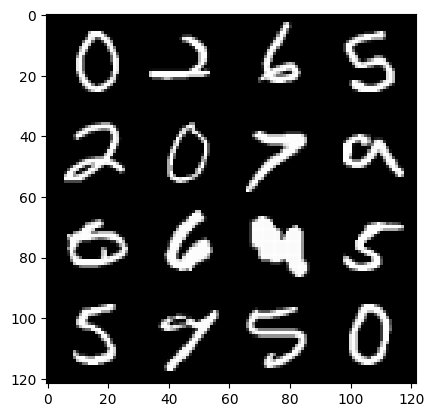

25: step 300 / Gen loss: 10.588694265683507 / Disc loss: 0.02546423572891702


  0%|          | 0/469 [00:00<?, ?it/s]

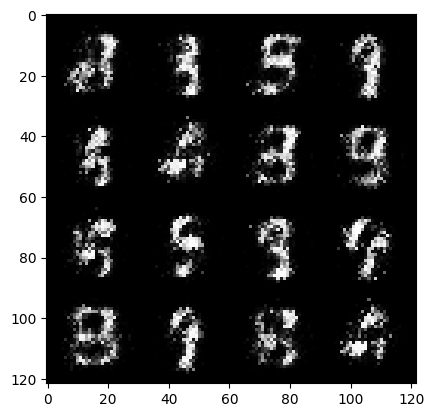

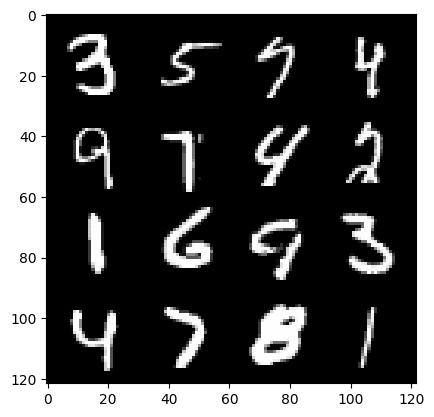

26: step 300 / Gen loss: 10.015029926300056 / Disc loss: 0.02898592324927446


  0%|          | 0/469 [00:00<?, ?it/s]

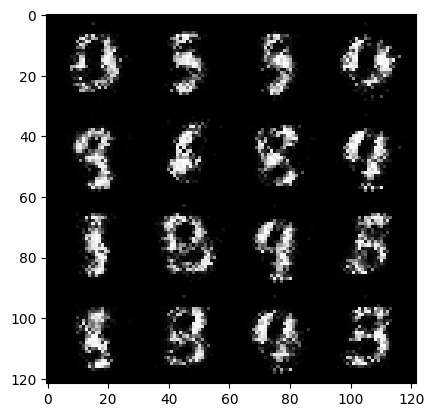

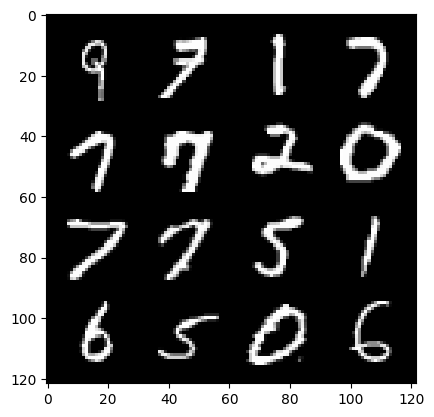

27: step 300 / Gen loss: 9.790427395502729 / Disc loss: 0.028429633360356088


  0%|          | 0/469 [00:00<?, ?it/s]

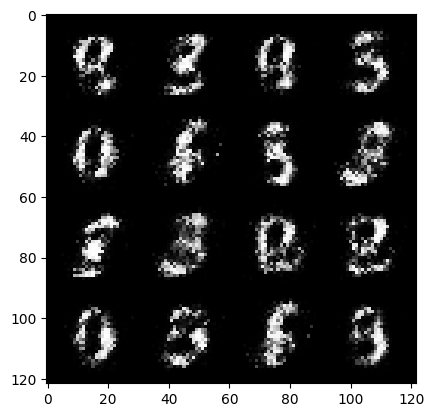

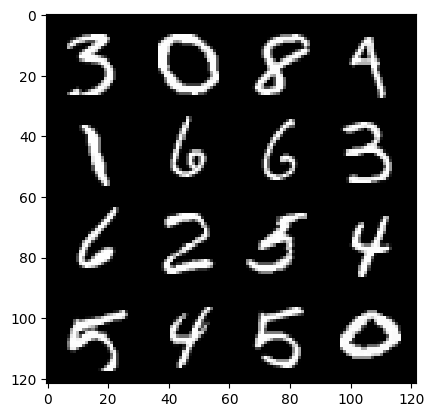

28: step 300 / Gen loss: 9.600308583577478 / Disc loss: 0.028822558436853163


  0%|          | 0/469 [00:00<?, ?it/s]

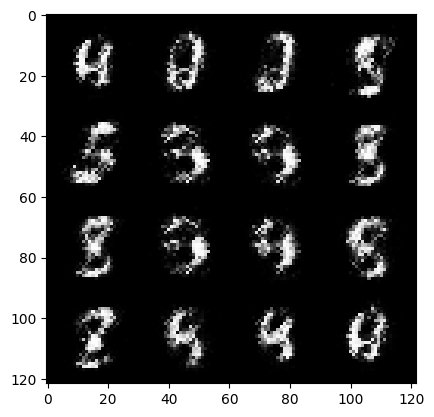

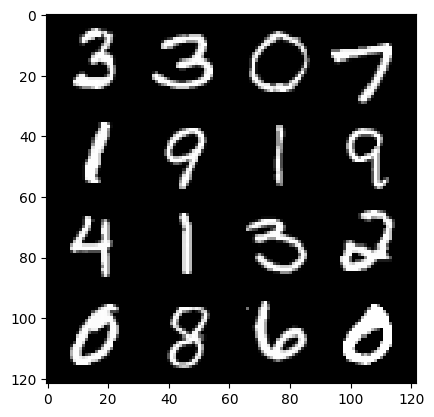

29: step 300 / Gen loss: 9.681893501281733 / Disc loss: 0.03486907779549555


  0%|          | 0/469 [00:00<?, ?it/s]

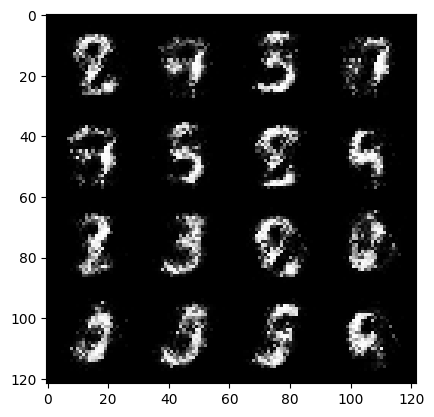

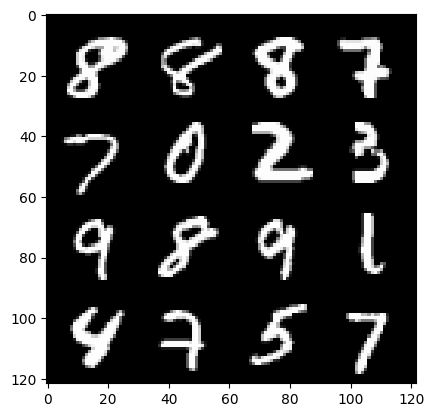

30: step 300 / Gen loss: 9.811775312423713 / Disc loss: 0.03560065469859792


  0%|          | 0/469 [00:00<?, ?it/s]

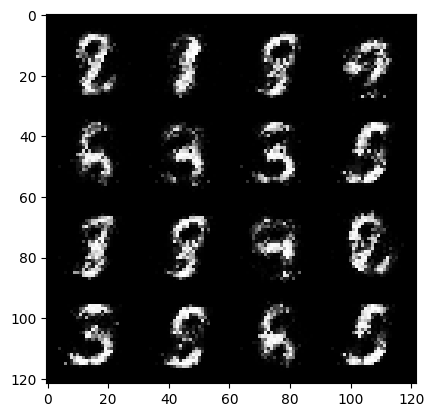

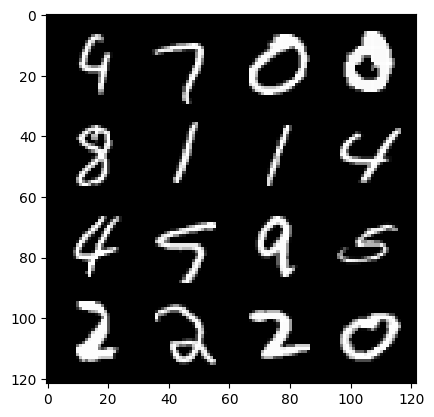

31: step 300 / Gen loss: 9.214790671666455 / Disc loss: 0.04430718960861365


  0%|          | 0/469 [00:00<?, ?it/s]

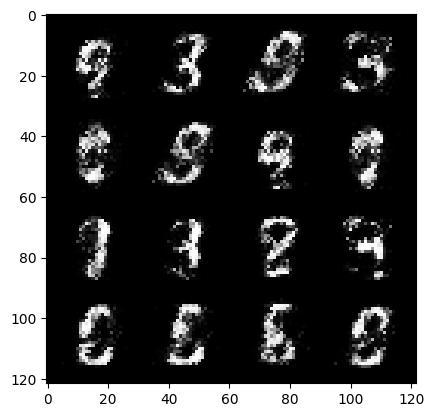

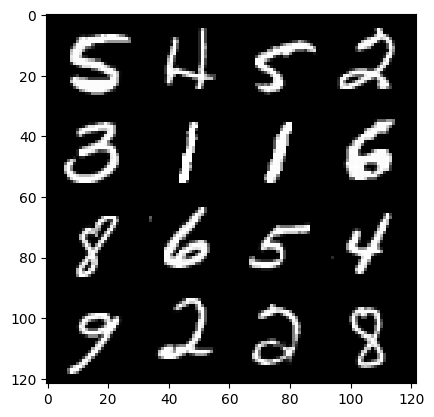

32: step 300 / Gen loss: 9.576274751027414 / Disc loss: 0.037875336930155754


  0%|          | 0/469 [00:00<?, ?it/s]

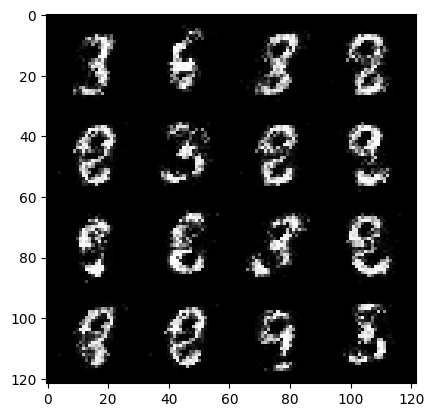

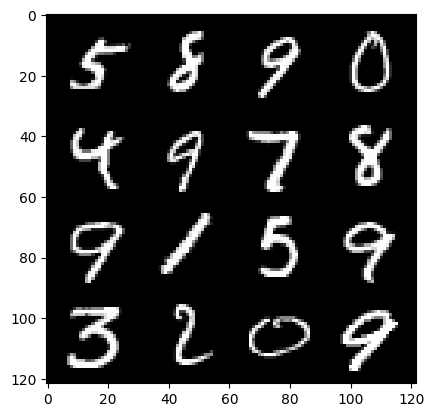

33: step 300 / Gen loss: 9.410771379470821 / Disc loss: 0.04393788076471538


  0%|          | 0/469 [00:00<?, ?it/s]

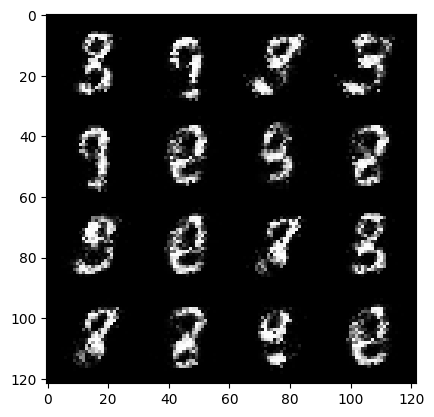

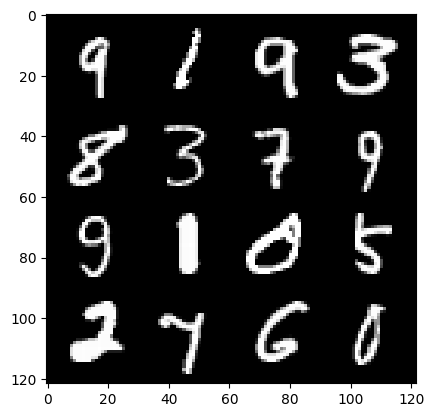

34: step 300 / Gen loss: 9.28555534680684 / Disc loss: 0.04794433259094758


  0%|          | 0/469 [00:00<?, ?it/s]

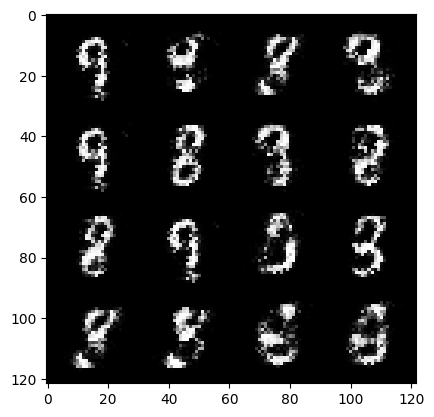

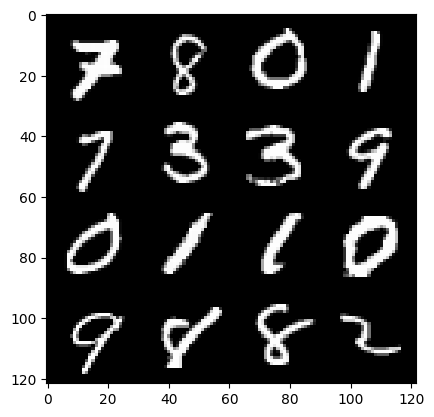

35: step 300 / Gen loss: 8.950437946319573 / Disc loss: 0.05180671425381053


  0%|          | 0/469 [00:00<?, ?it/s]

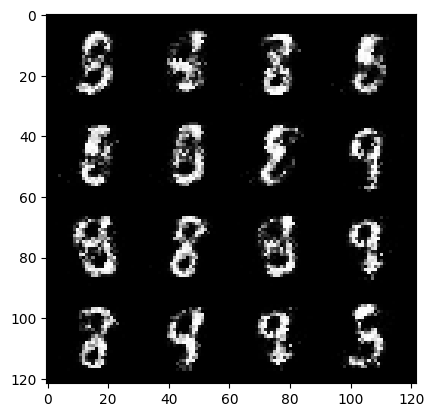

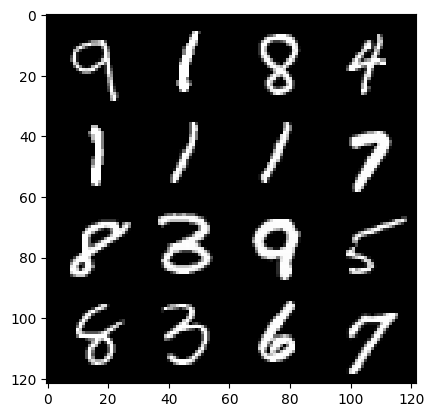

36: step 300 / Gen loss: 8.817043674786891 / Disc loss: 0.04762598842071989


  0%|          | 0/469 [00:00<?, ?it/s]

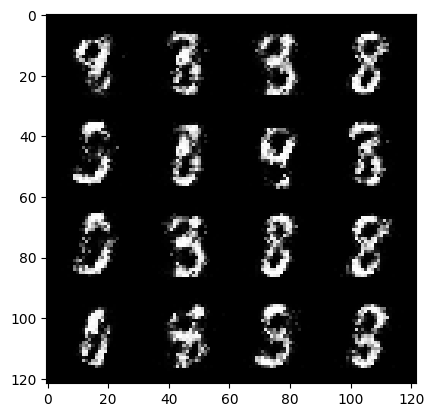

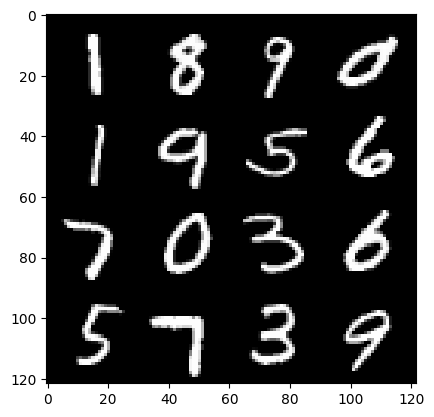

37: step 300 / Gen loss: 9.023523681958512 / Disc loss: 0.0627915694455927


  0%|          | 0/469 [00:00<?, ?it/s]

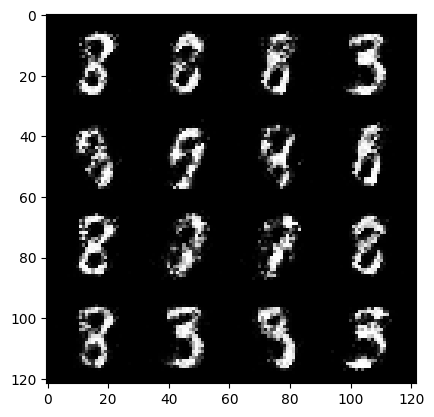

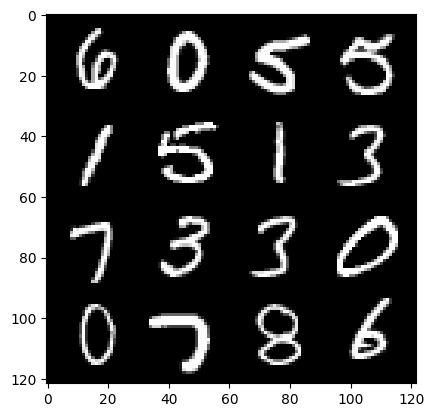

38: step 300 / Gen loss: 8.63667457580566 / Disc loss: 0.06498231291926151


  0%|          | 0/469 [00:00<?, ?it/s]

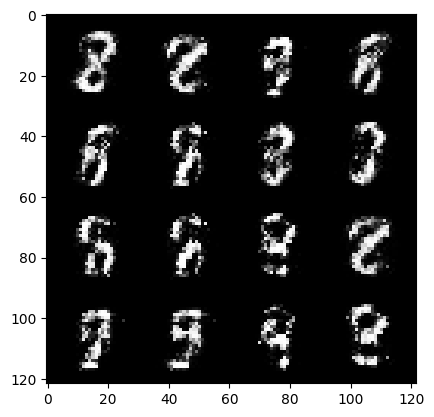

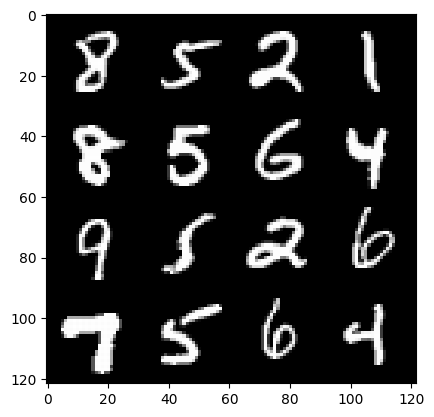

39: step 300 / Gen loss: 8.241961874961852 / Disc loss: 0.07513781239589051


  0%|          | 0/469 [00:00<?, ?it/s]

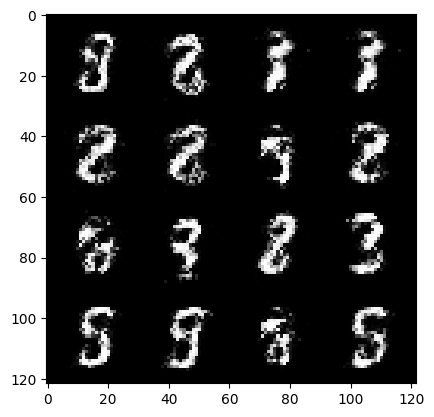

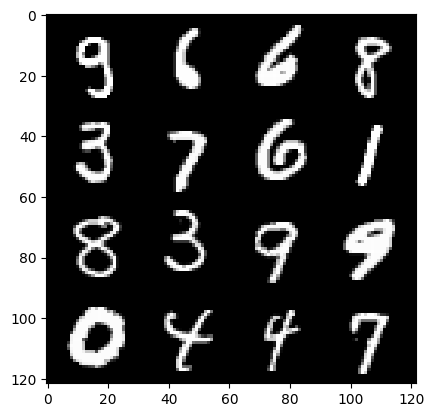

40: step 300 / Gen loss: 8.20967533906301 / Disc loss: 0.06839268221830326


  0%|          | 0/469 [00:00<?, ?it/s]

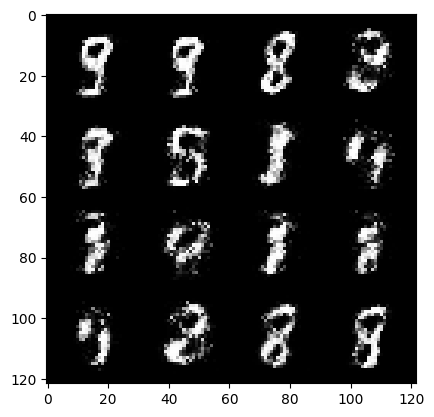

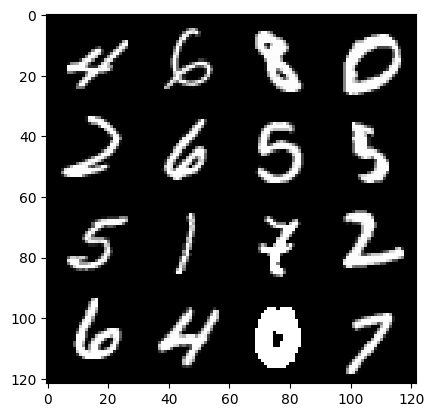

41: step 300 / Gen loss: 8.615406872431445 / Disc loss: 0.07151694304309789


  0%|          | 0/469 [00:00<?, ?it/s]

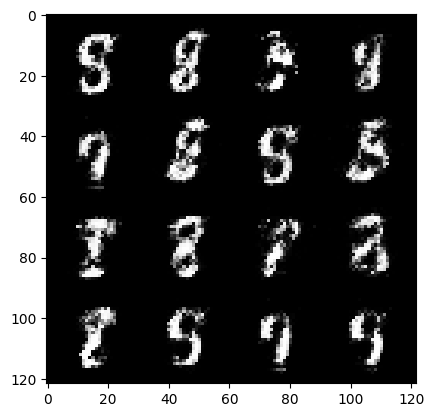

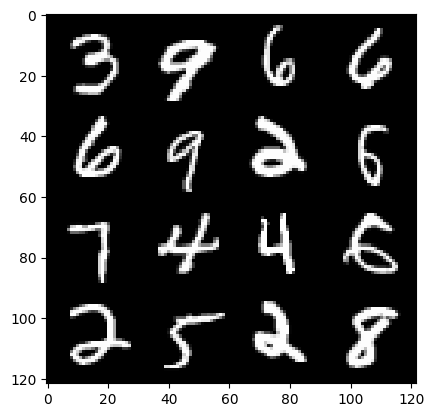

42: step 300 / Gen loss: 8.43304730256399 / Disc loss: 0.07403293925027056


  0%|          | 0/469 [00:00<?, ?it/s]

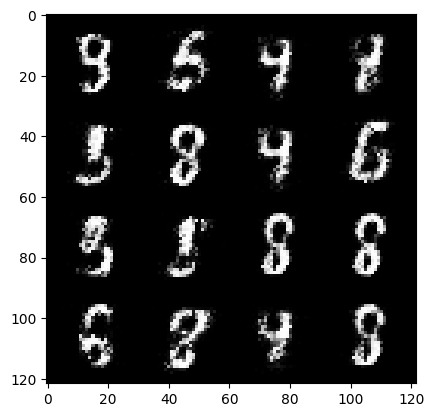

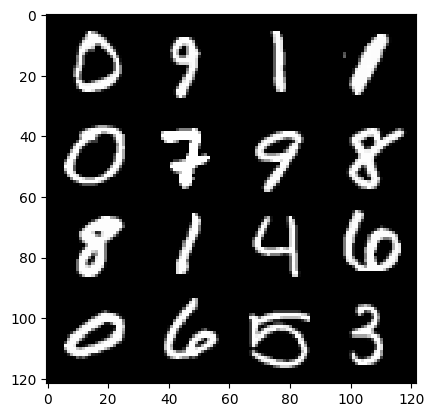

43: step 300 / Gen loss: 8.229736863772072 / Disc loss: 0.08112520520885792


  0%|          | 0/469 [00:00<?, ?it/s]

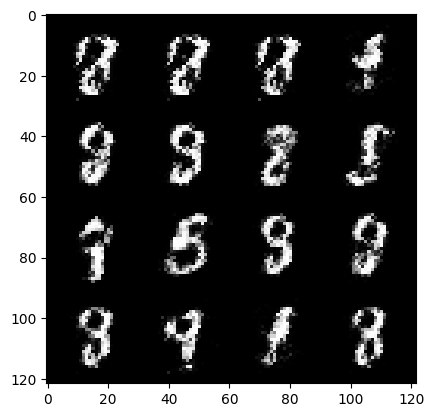

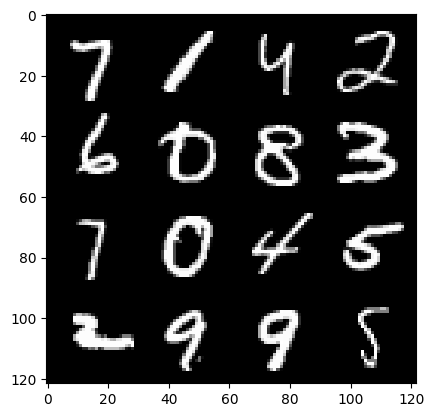

44: step 300 / Gen loss: 7.74138416767121 / Disc loss: 0.08877670861780654


  0%|          | 0/469 [00:00<?, ?it/s]

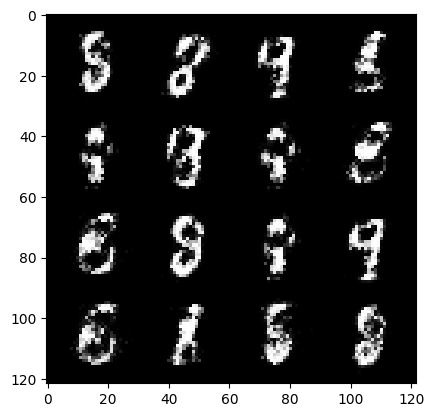

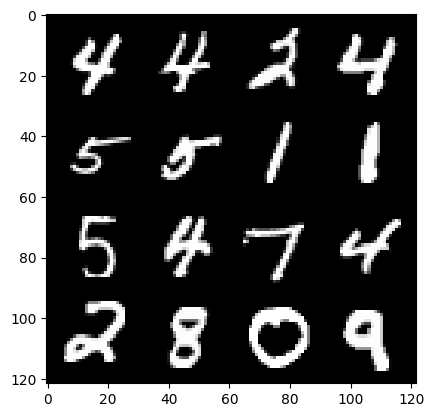

45: step 300 / Gen loss: 8.255630237261451 / Disc loss: 0.07599920227192339


  0%|          | 0/469 [00:00<?, ?it/s]

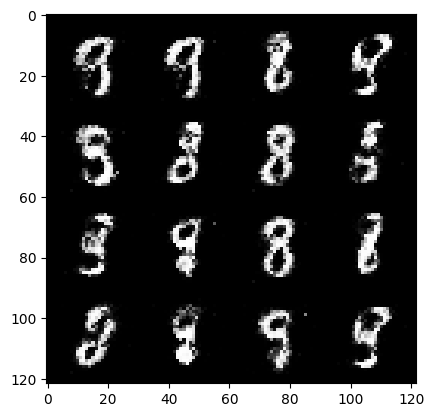

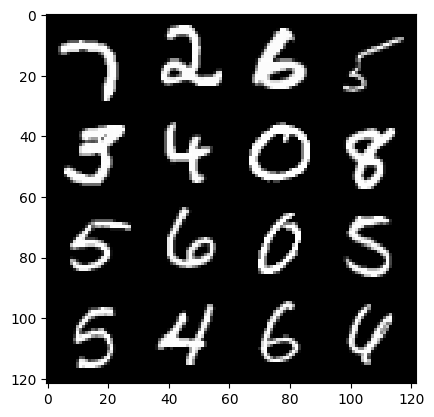

46: step 300 / Gen loss: 8.668370043436688 / Disc loss: 0.0740540038483838


  0%|          | 0/469 [00:00<?, ?it/s]

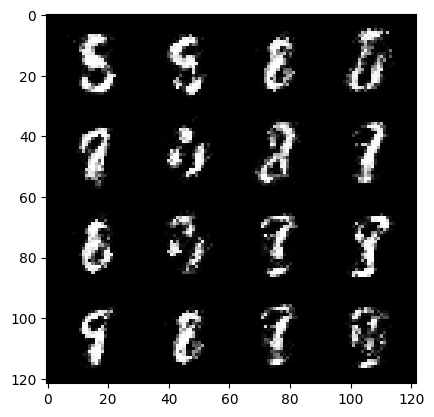

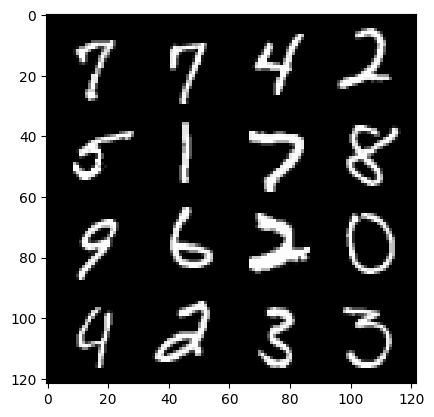

47: step 300 / Gen loss: 7.890285560290017 / Disc loss: 0.08915723593905564


  0%|          | 0/469 [00:00<?, ?it/s]

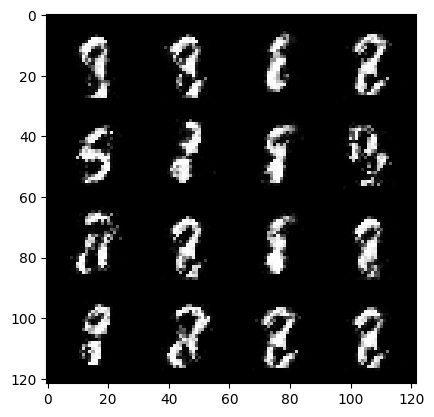

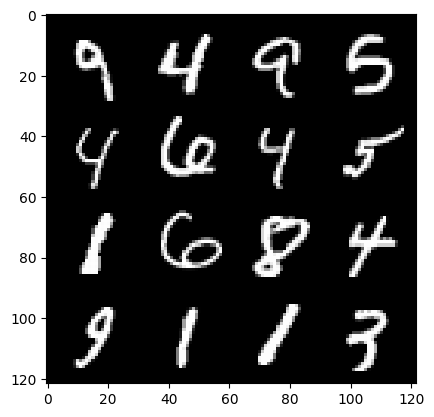

48: step 300 / Gen loss: 7.919213013648983 / Disc loss: 0.08810219464823597


  0%|          | 0/469 [00:00<?, ?it/s]

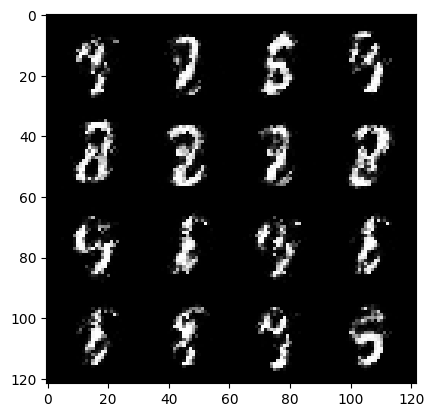

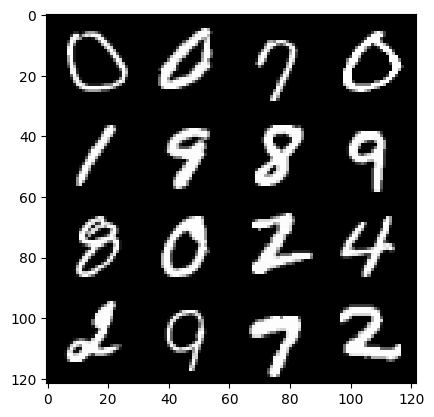

49: step 300 / Gen loss: 7.932300011316937 / Disc loss: 0.09095025476068265


  0%|          | 0/469 [00:00<?, ?it/s]

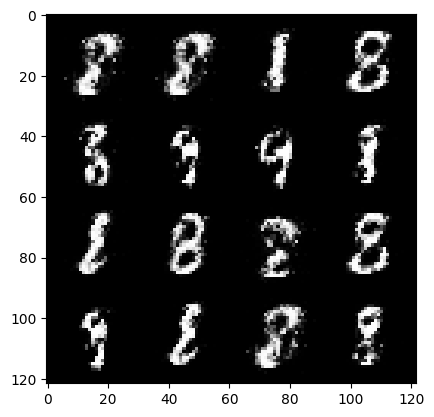

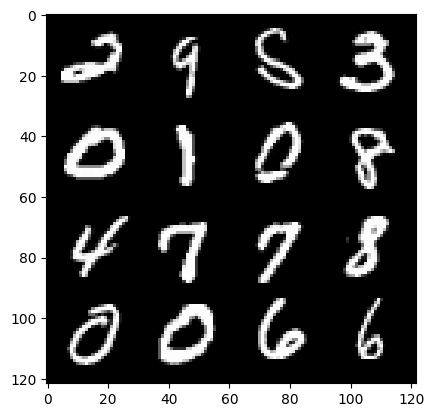

50: step 300 / Gen loss: 7.64529219309489 / Disc loss: 0.10256602055703598


  0%|          | 0/469 [00:00<?, ?it/s]

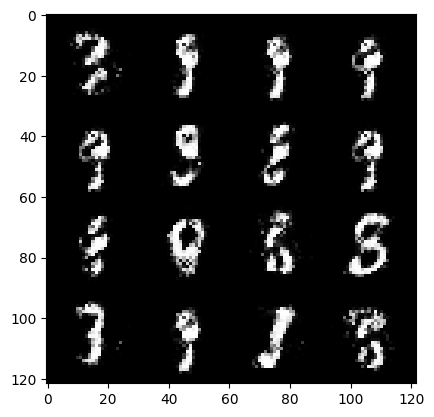

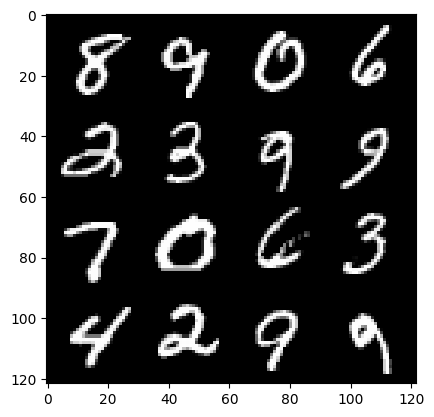

51: step 300 / Gen loss: 7.519202371438342 / Disc loss: 0.11941057839120414


  0%|          | 0/469 [00:00<?, ?it/s]

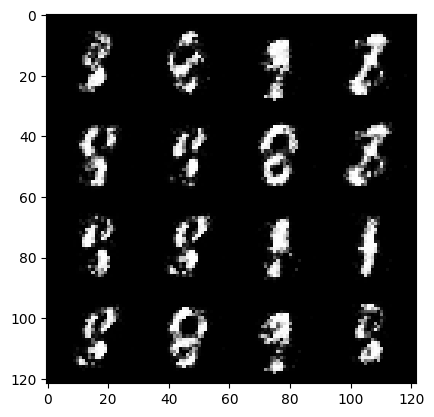

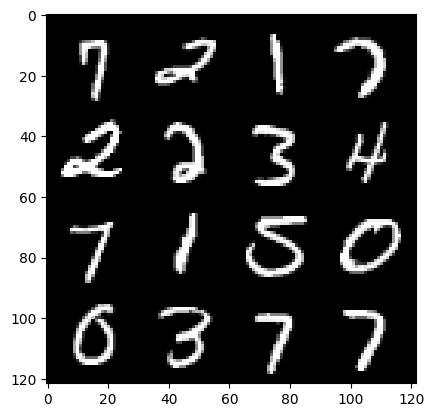

52: step 300 / Gen loss: 7.596419977347058 / Disc loss: 0.10441115764901046


  0%|          | 0/469 [00:00<?, ?it/s]

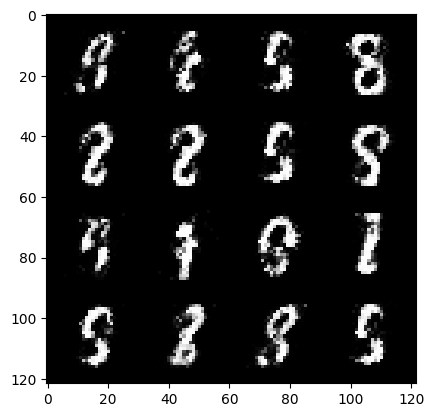

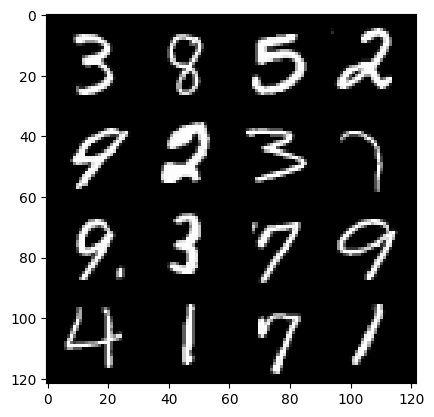

53: step 300 / Gen loss: 7.4517741052309665 / Disc loss: 0.1102609310268113


  0%|          | 0/469 [00:00<?, ?it/s]

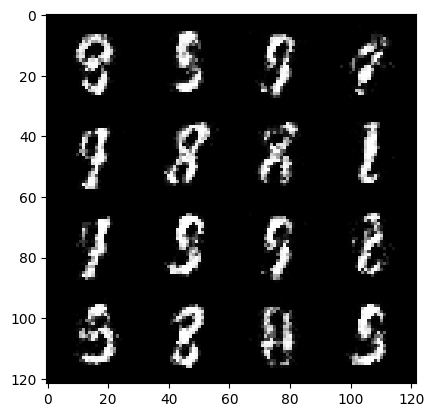

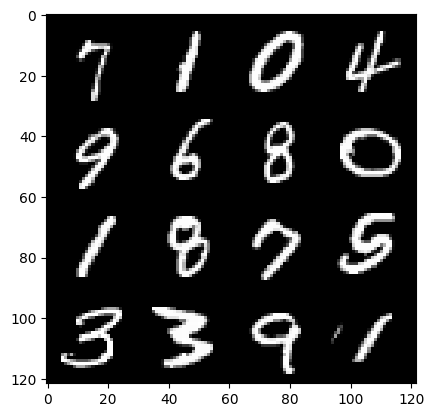

54: step 300 / Gen loss: 7.5871663117408845 / Disc loss: 0.1340109308560689


  0%|          | 0/469 [00:00<?, ?it/s]

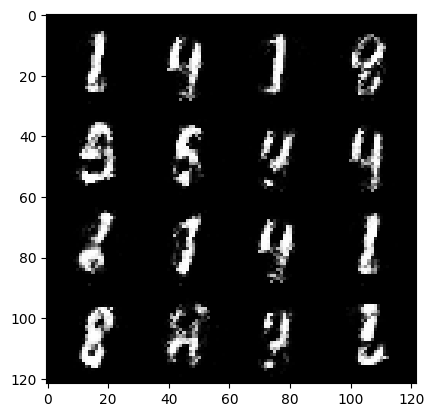

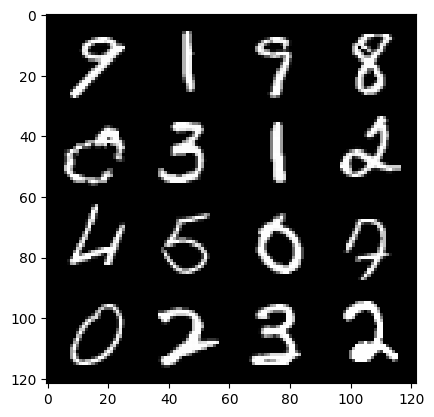

55: step 300 / Gen loss: 7.012725556691486 / Disc loss: 0.1440348877757788


  0%|          | 0/469 [00:00<?, ?it/s]

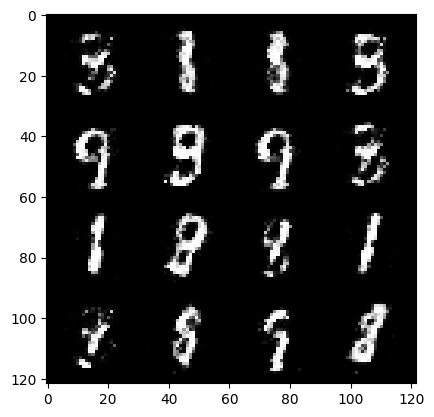

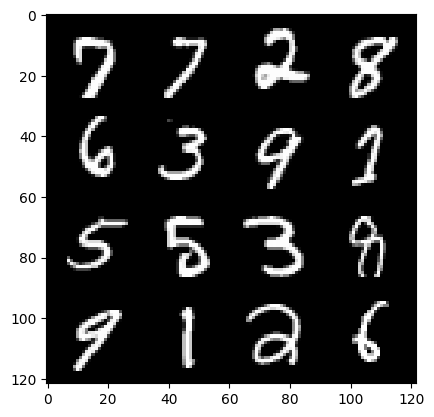

56: step 300 / Gen loss: 6.915630424022669 / Disc loss: 0.1456580248226722


  0%|          | 0/469 [00:00<?, ?it/s]

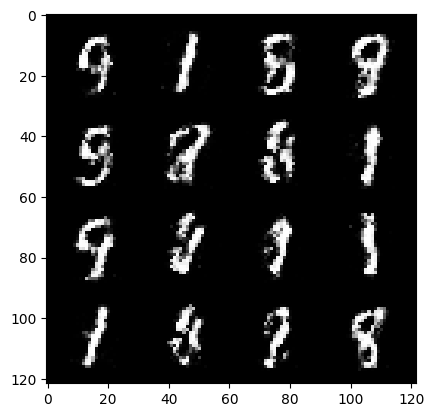

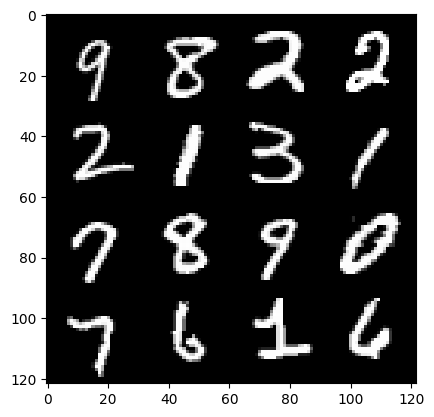

57: step 300 / Gen loss: 6.601482048829395 / Disc loss: 0.16781120873987684


  0%|          | 0/469 [00:00<?, ?it/s]

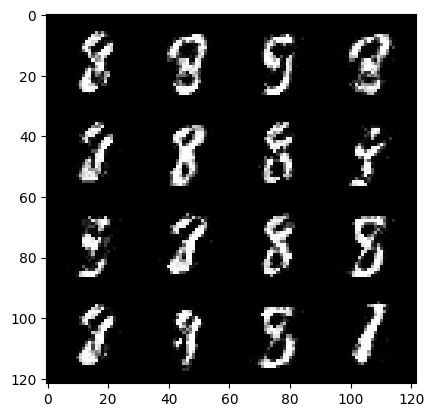

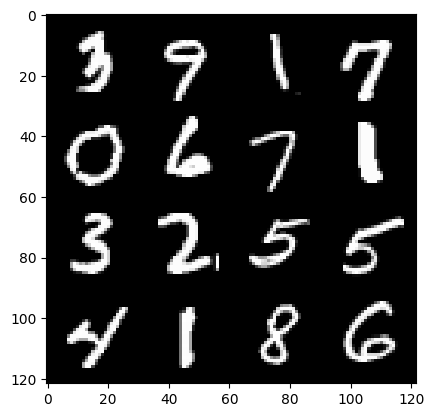

58: step 300 / Gen loss: 6.681127948760989 / Disc loss: 0.16021155534933024


  0%|          | 0/469 [00:00<?, ?it/s]

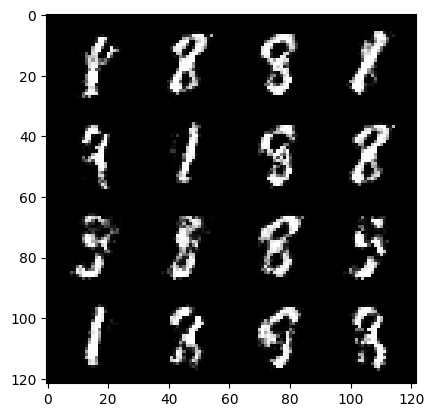

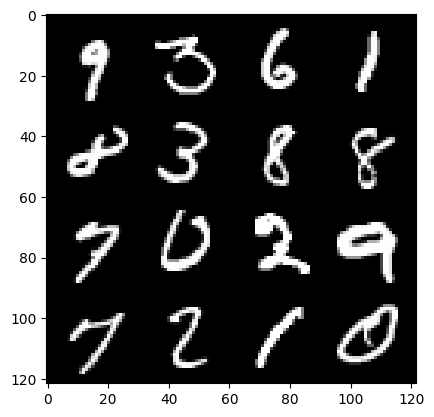

59: step 300 / Gen loss: 6.393995820681255 / Disc loss: 0.1895372823501625


  0%|          | 0/469 [00:00<?, ?it/s]

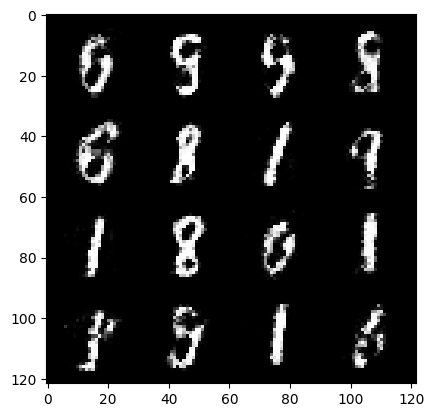

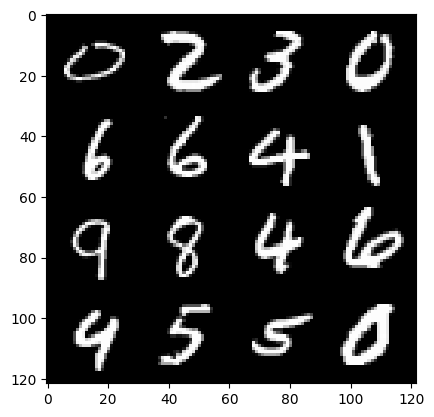

60: step 300 / Gen loss: 6.170552314917244 / Disc loss: 0.2099428185199699


  0%|          | 0/469 [00:00<?, ?it/s]

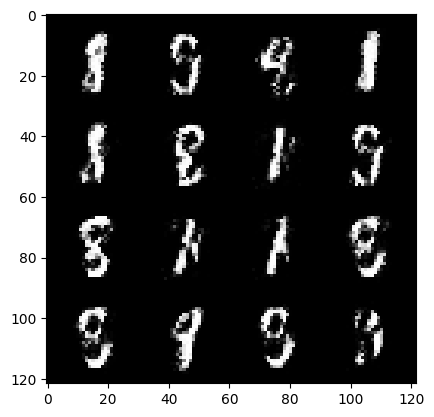

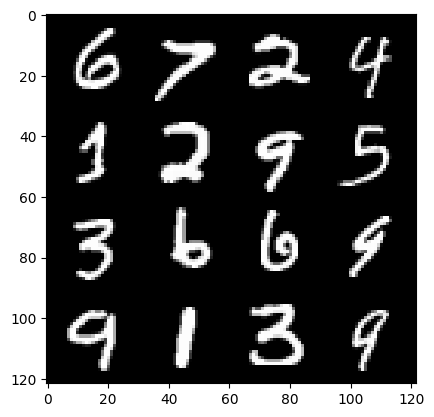

61: step 300 / Gen loss: 5.939709982077276 / Disc loss: 0.21534278328220058


  0%|          | 0/469 [00:00<?, ?it/s]

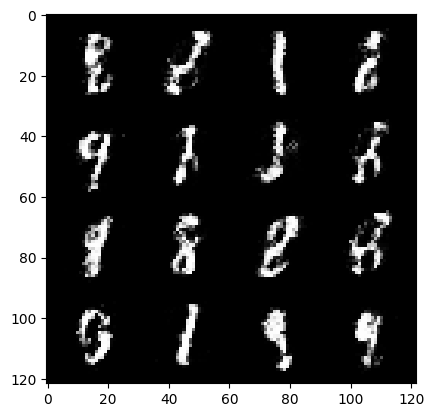

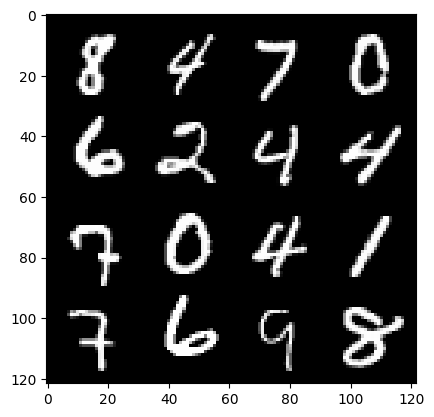

62: step 300 / Gen loss: 5.964542768001559 / Disc loss: 0.21983944042275358


  0%|          | 0/469 [00:00<?, ?it/s]

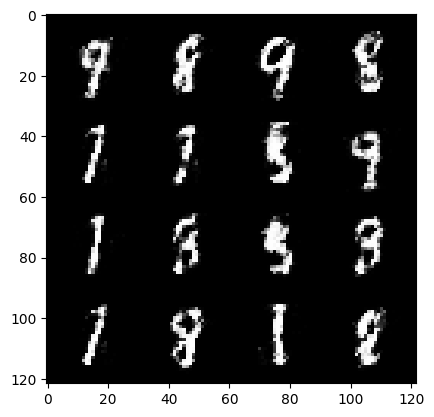

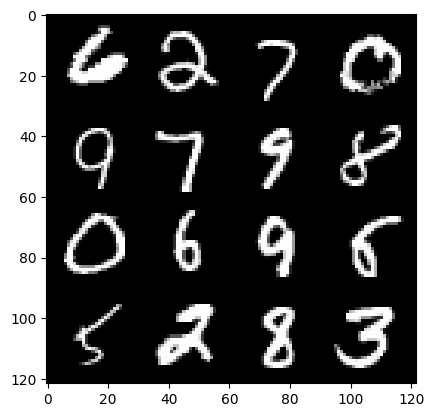

63: step 300 / Gen loss: 5.733703400293984 / Disc loss: 0.2488060655817388


  0%|          | 0/469 [00:00<?, ?it/s]

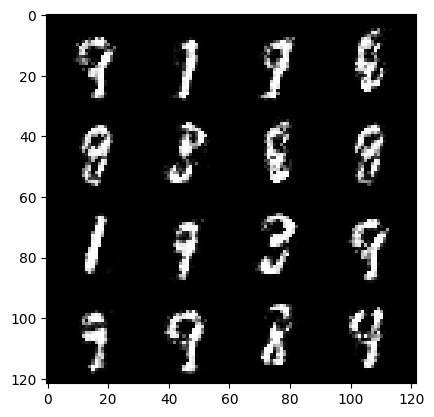

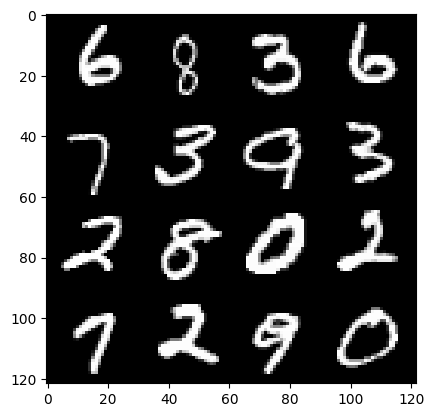

64: step 300 / Gen loss: 5.475478854974106 / Disc loss: 0.2645039141426482


  0%|          | 0/469 [00:00<?, ?it/s]

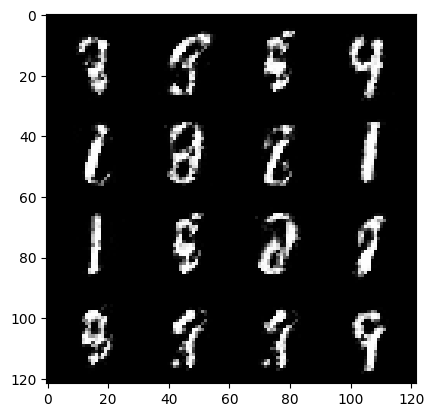

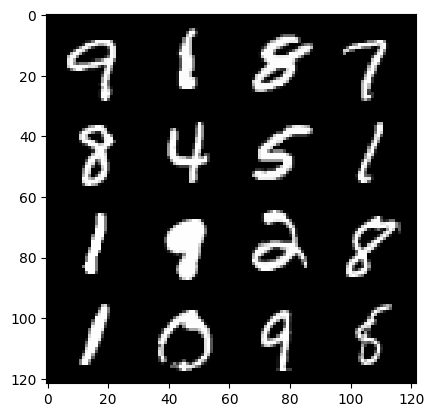

65: step 300 / Gen loss: 5.534975934028634 / Disc loss: 0.24568973859151189


  0%|          | 0/469 [00:00<?, ?it/s]

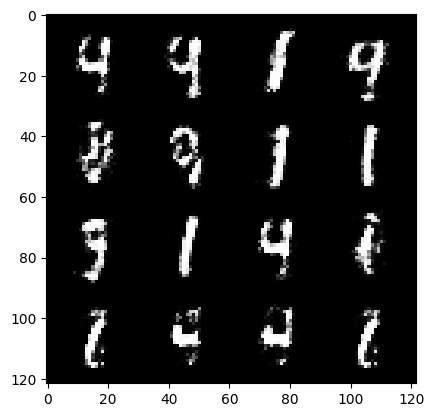

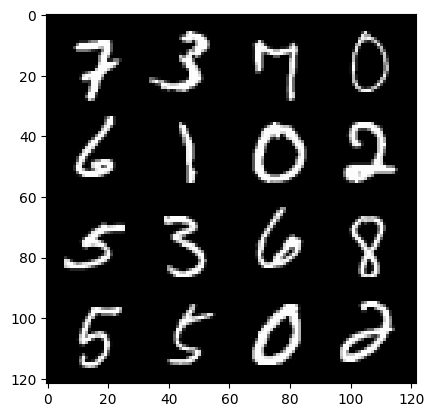

66: step 300 / Gen loss: 5.317185103098553 / Disc loss: 0.2563008065521716


  0%|          | 0/469 [00:00<?, ?it/s]

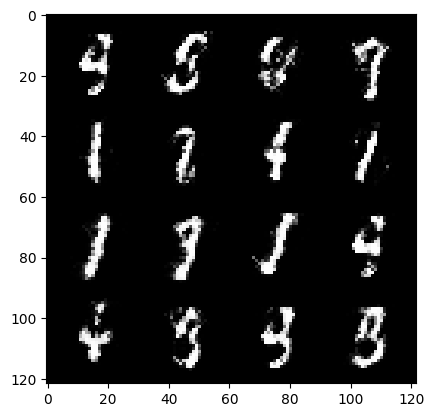

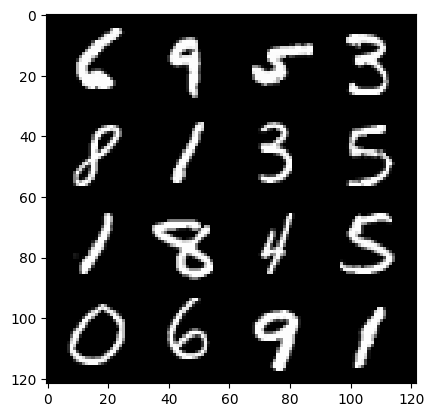

67: step 300 / Gen loss: 5.405093987782798 / Disc loss: 0.24068457769850884


  0%|          | 0/469 [00:00<?, ?it/s]

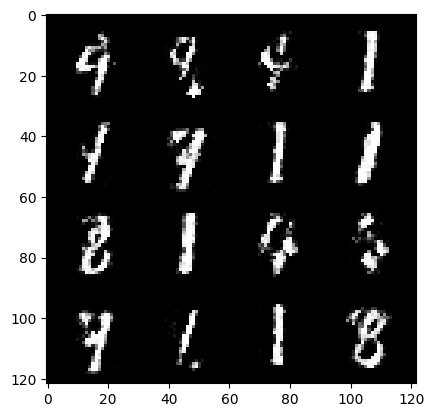

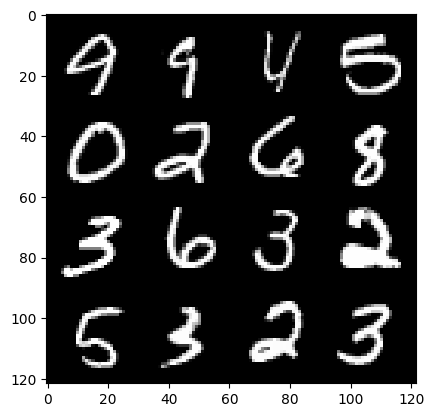

68: step 300 / Gen loss: 5.451219886938732 / Disc loss: 0.24660192208985482


  0%|          | 0/469 [00:00<?, ?it/s]

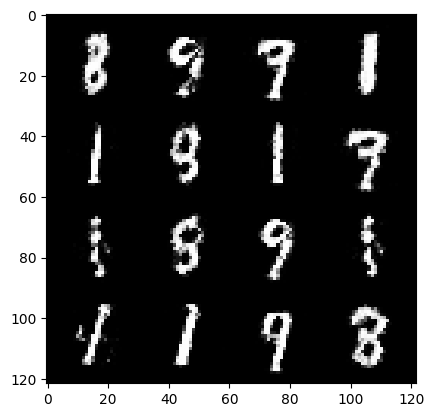

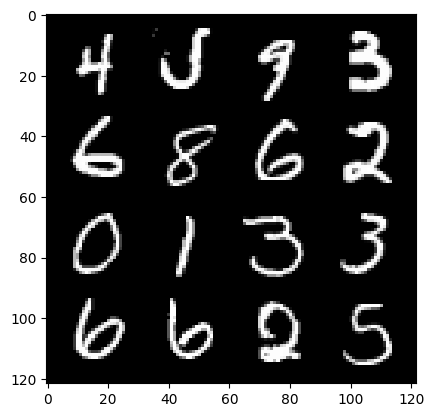

69: step 300 / Gen loss: 5.313482272624975 / Disc loss: 0.26750001023213077


  0%|          | 0/469 [00:00<?, ?it/s]

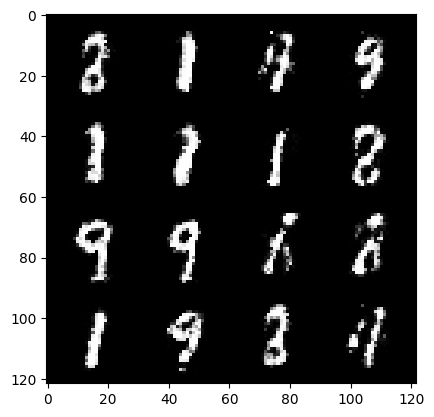

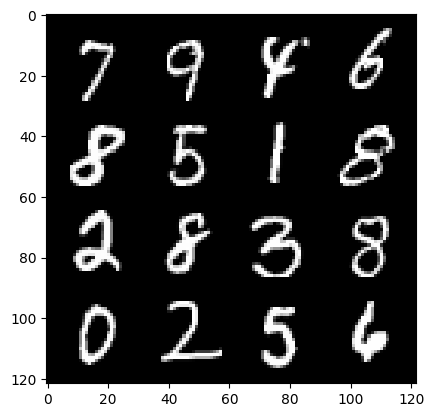

70: step 300 / Gen loss: 5.250050292015079 / Disc loss: 0.2560084515561661


  0%|          | 0/469 [00:00<?, ?it/s]

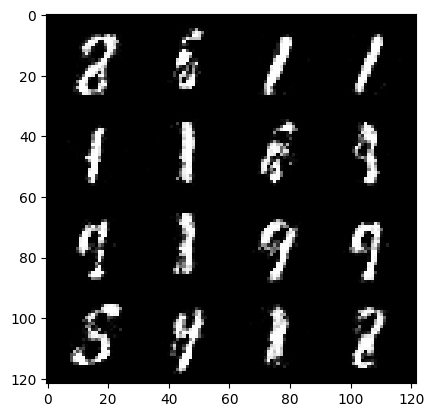

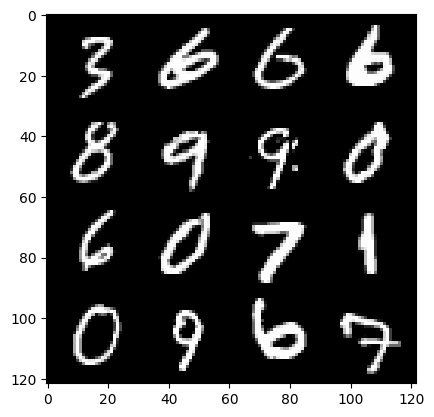

71: step 300 / Gen loss: 5.01771264473597 / Disc loss: 0.28130121511717615


  0%|          | 0/469 [00:00<?, ?it/s]

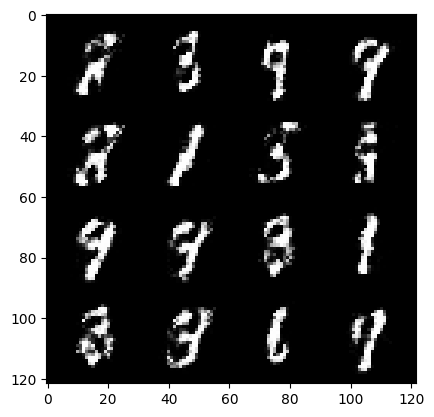

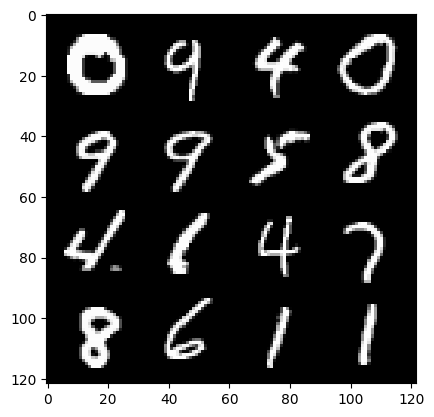

72: step 300 / Gen loss: 4.954816884199778 / Disc loss: 0.28589548493425065


  0%|          | 0/469 [00:00<?, ?it/s]

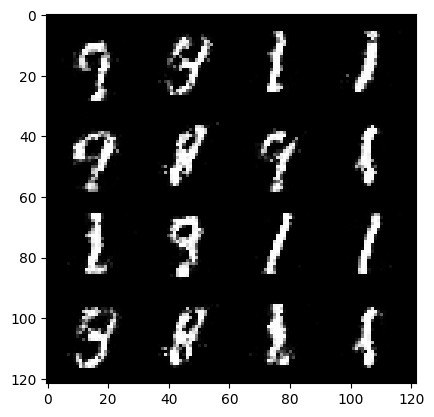

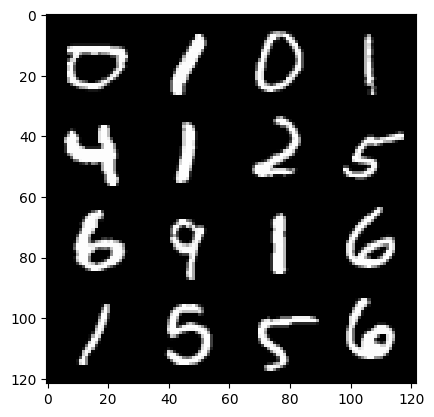

73: step 300 / Gen loss: 5.026863623460133 / Disc loss: 0.2787290221452715


  0%|          | 0/469 [00:00<?, ?it/s]

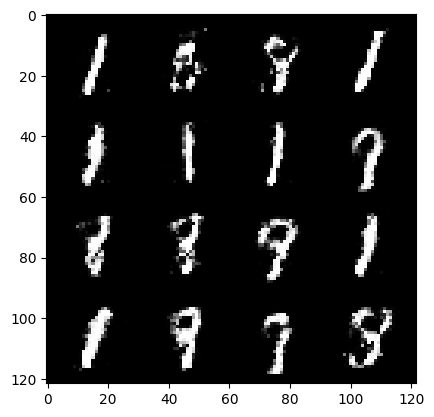

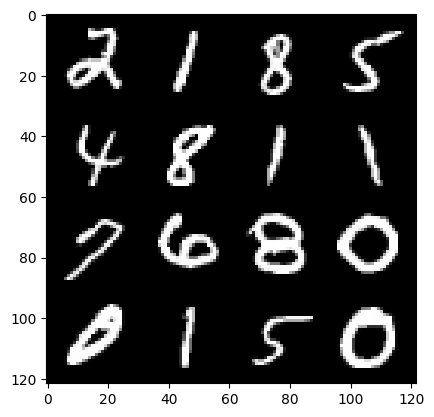

74: step 300 / Gen loss: 4.936352817217507 / Disc loss: 0.2724033159514269


  0%|          | 0/469 [00:00<?, ?it/s]

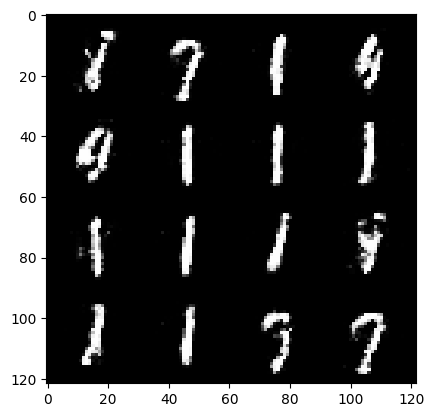

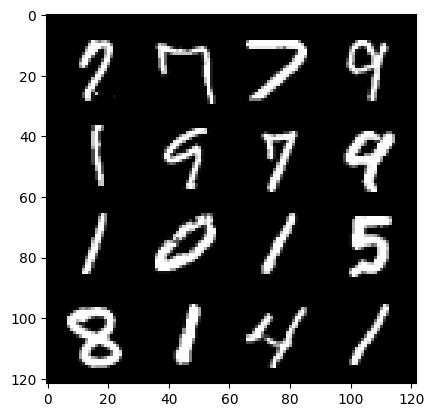

75: step 300 / Gen loss: 4.99186658302943 / Disc loss: 0.2882887217899162


  0%|          | 0/469 [00:00<?, ?it/s]

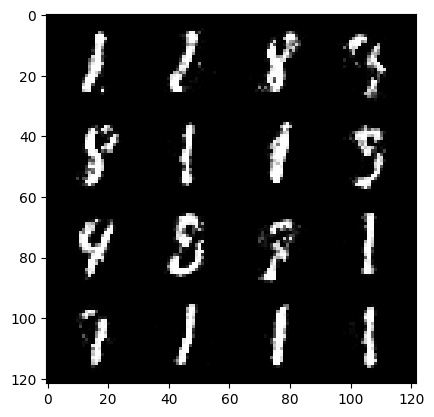

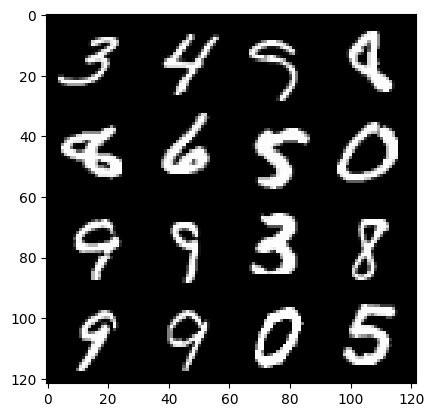

76: step 300 / Gen loss: 4.727248061498014 / Disc loss: 0.29975908828278364


  0%|          | 0/469 [00:00<?, ?it/s]

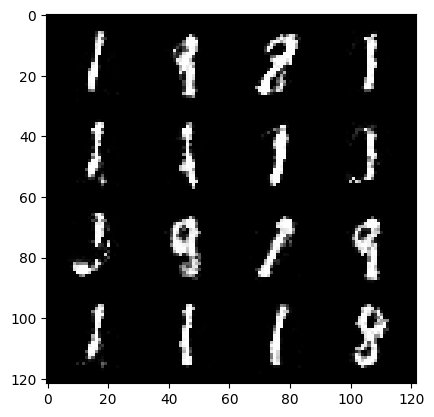

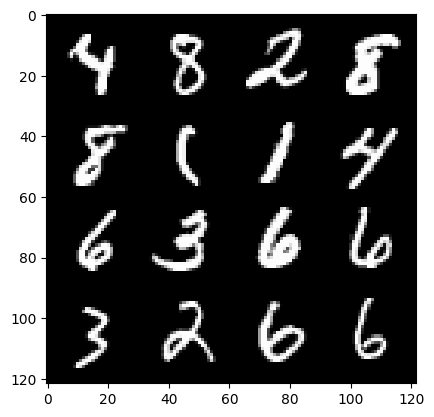

77: step 300 / Gen loss: 4.639259990851086 / Disc loss: 0.29493489086627944


  0%|          | 0/469 [00:00<?, ?it/s]

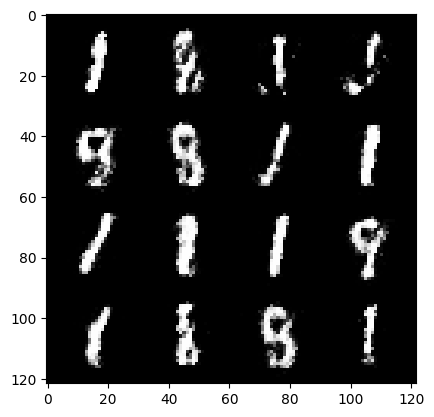

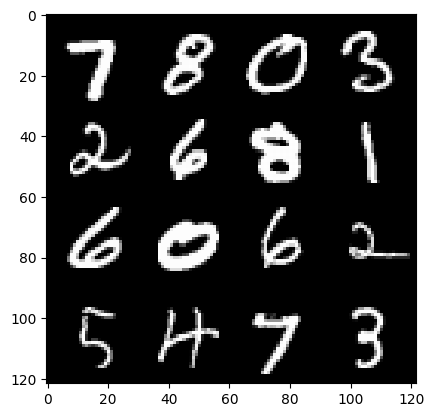

78: step 300 / Gen loss: 4.643714712460838 / Disc loss: 0.29046110267440495


  0%|          | 0/469 [00:00<?, ?it/s]

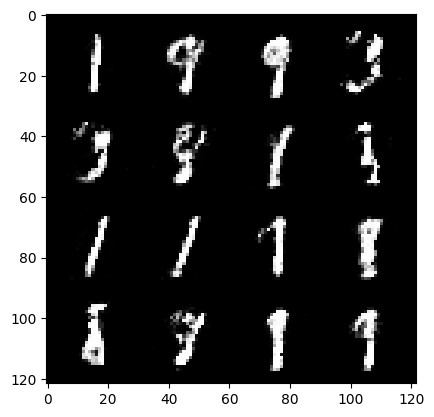

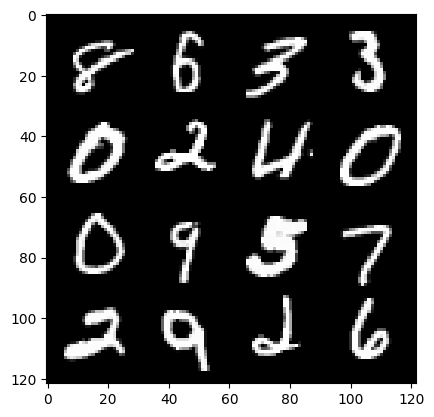

79: step 300 / Gen loss: 4.445812433560689 / Disc loss: 0.30683331847190853


  0%|          | 0/469 [00:00<?, ?it/s]

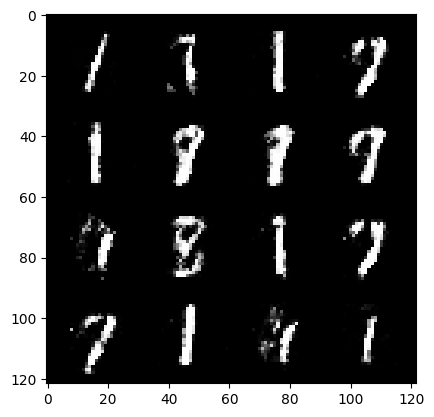

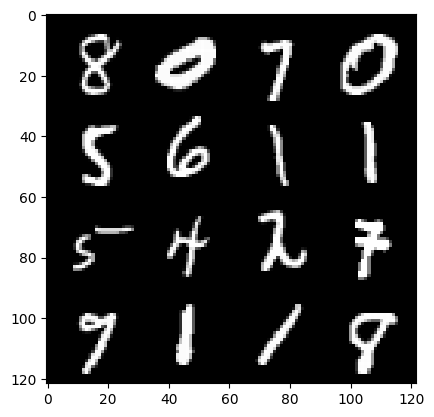

80: step 300 / Gen loss: 4.4775125932693465 / Disc loss: 0.2983041848987343


  0%|          | 0/469 [00:00<?, ?it/s]

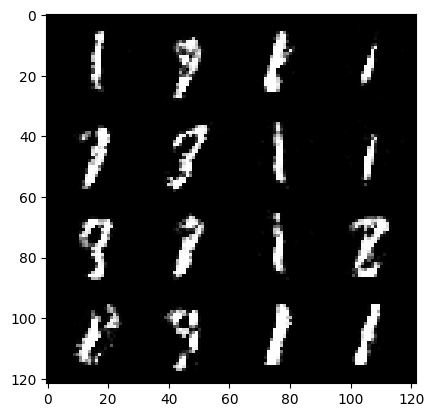

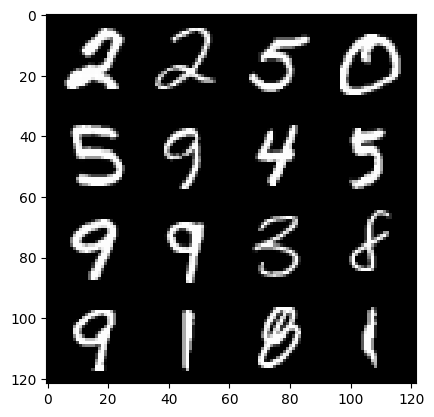

81: step 300 / Gen loss: 4.4600430162747715 / Disc loss: 0.31356733237703643


  0%|          | 0/469 [00:00<?, ?it/s]

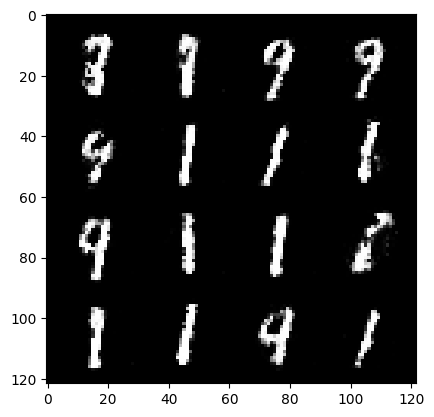

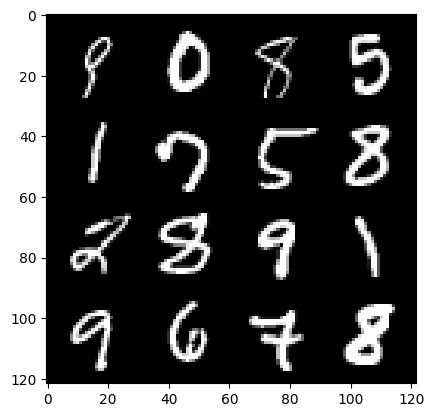

82: step 300 / Gen loss: 4.4345392012596125 / Disc loss: 0.32039537342886115


  0%|          | 0/469 [00:00<?, ?it/s]

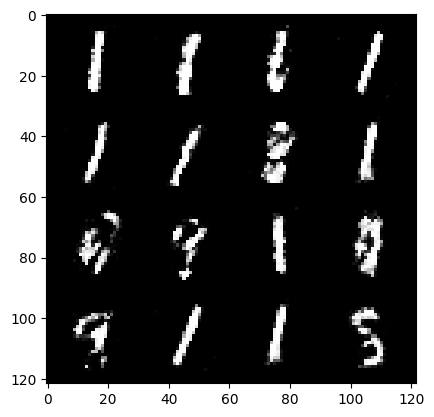

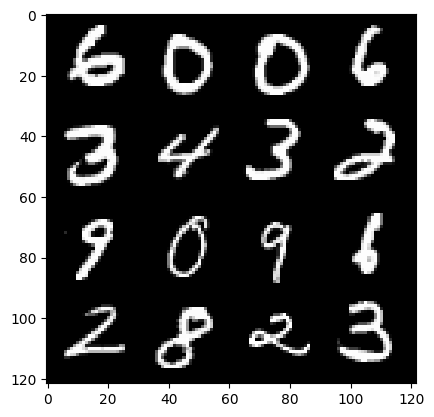

83: step 300 / Gen loss: 4.1611291615168255 / Disc loss: 0.3345763390262922


  0%|          | 0/469 [00:00<?, ?it/s]

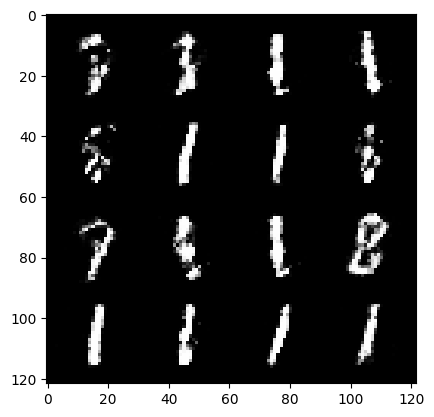

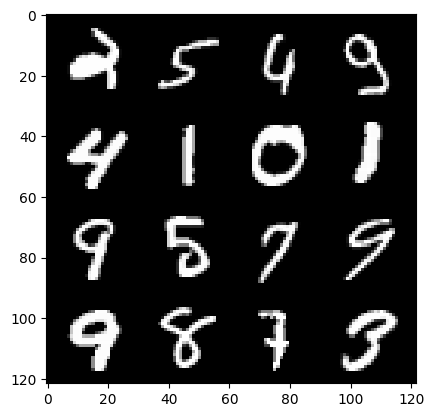

84: step 300 / Gen loss: 4.032997368574143 / Disc loss: 0.34734040811657896


  0%|          | 0/469 [00:00<?, ?it/s]

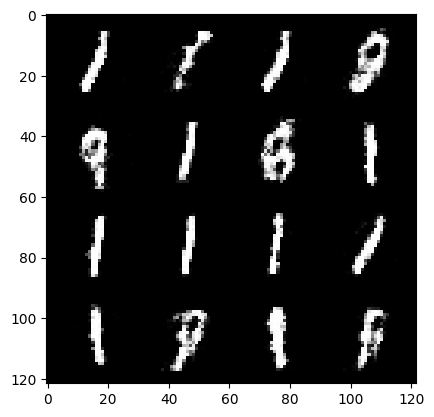

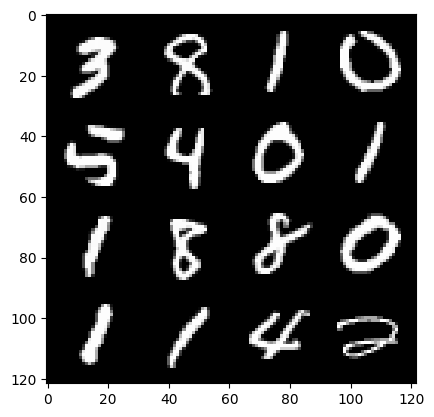

85: step 300 / Gen loss: 4.065814813772833 / Disc loss: 0.3473704820374646


  0%|          | 0/469 [00:00<?, ?it/s]

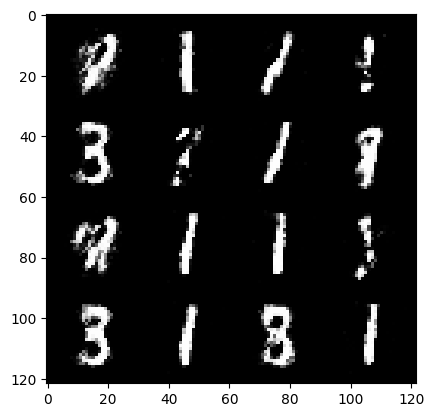

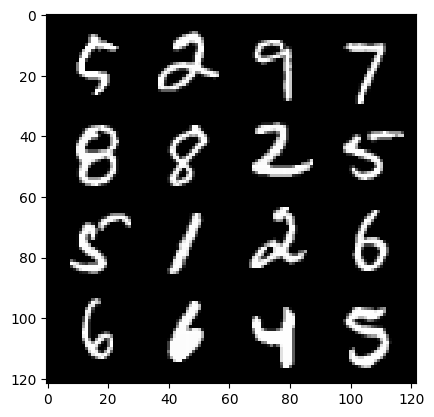

86: step 300 / Gen loss: 3.9500967168808017 / Disc loss: 0.3433128392696379


  0%|          | 0/469 [00:00<?, ?it/s]

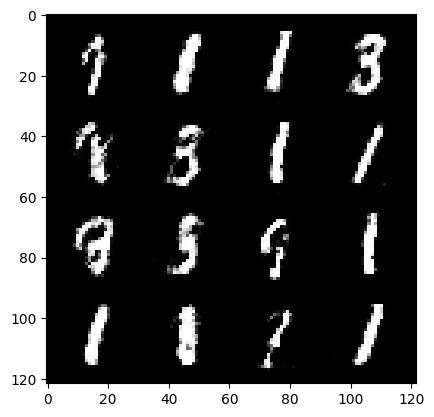

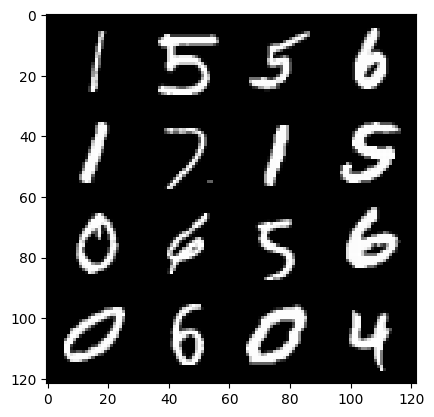

87: step 300 / Gen loss: 4.0433813134829215 / Disc loss: 0.32848544167975624


  0%|          | 0/469 [00:00<?, ?it/s]

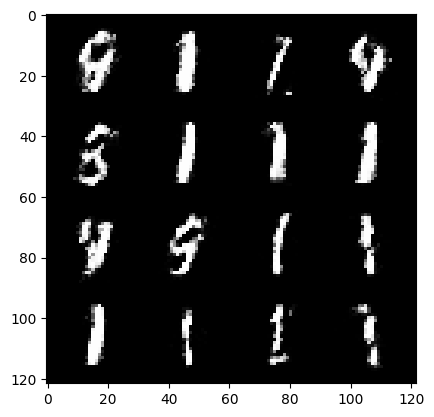

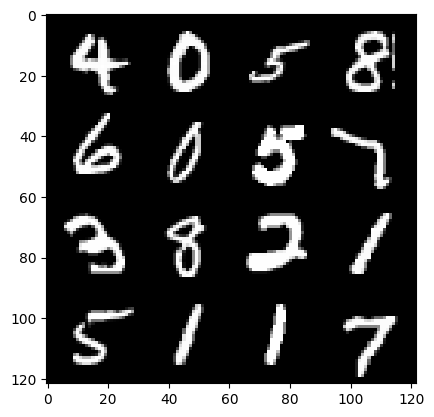

88: step 300 / Gen loss: 3.9491989747683185 / Disc loss: 0.34147299351791527


  0%|          | 0/469 [00:00<?, ?it/s]

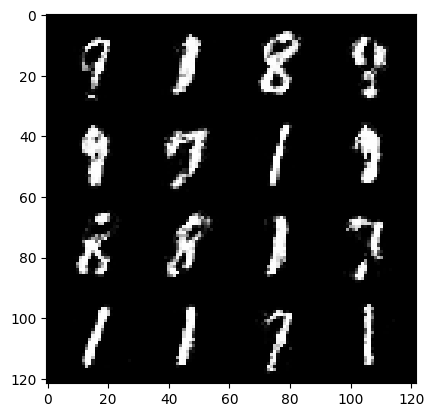

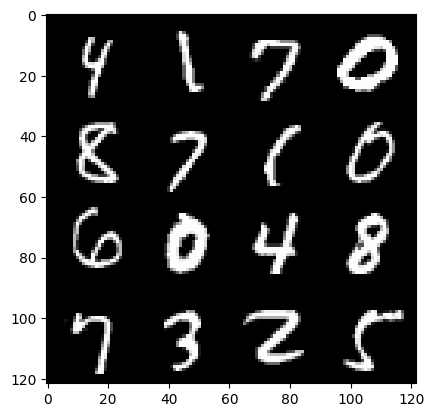

89: step 300 / Gen loss: 3.964715549945831 / Disc loss: 0.3690140368789434


  0%|          | 0/469 [00:00<?, ?it/s]

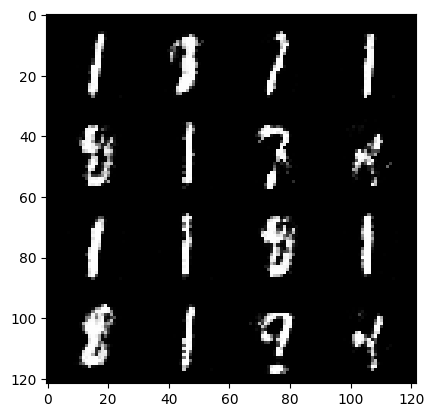

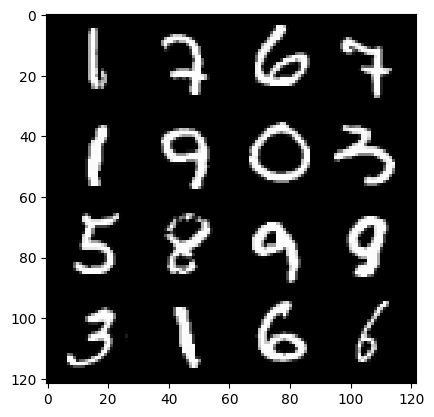

90: step 300 / Gen loss: 3.815078654289244 / Disc loss: 0.3723206111292043


  0%|          | 0/469 [00:00<?, ?it/s]

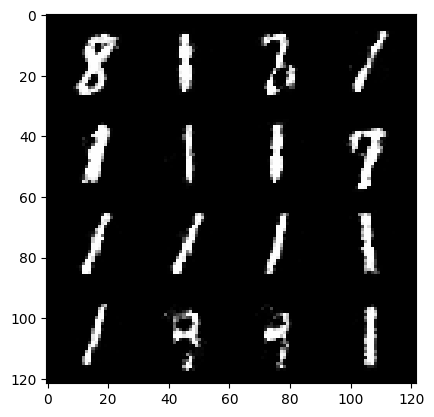

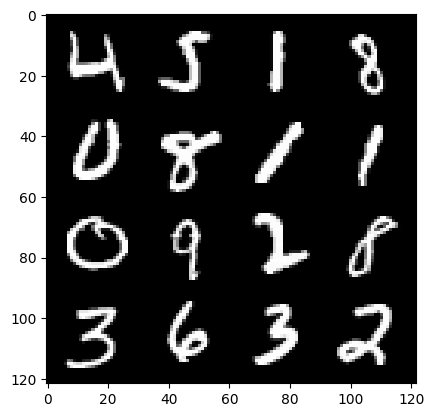

91: step 300 / Gen loss: 3.86450377543767 / Disc loss: 0.36142392118771877


  0%|          | 0/469 [00:00<?, ?it/s]

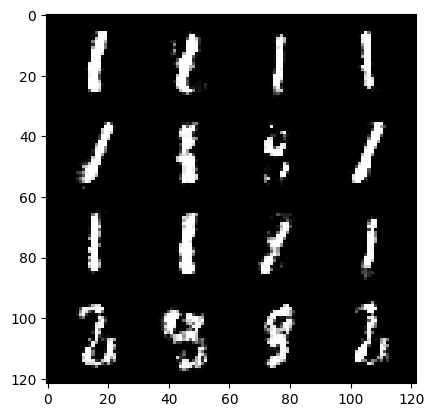

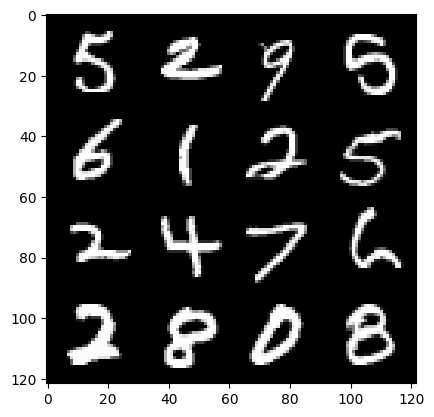

92: step 300 / Gen loss: 3.814680354197823 / Disc loss: 0.3814100112517676


  0%|          | 0/469 [00:00<?, ?it/s]

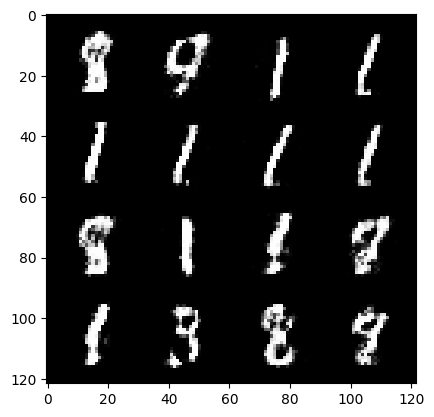

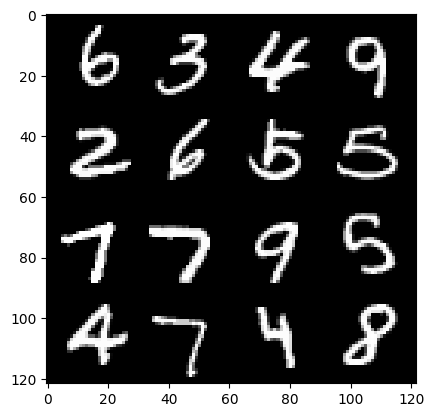

93: step 300 / Gen loss: 3.743349605798725 / Disc loss: 0.371647433042526


  0%|          | 0/469 [00:00<?, ?it/s]

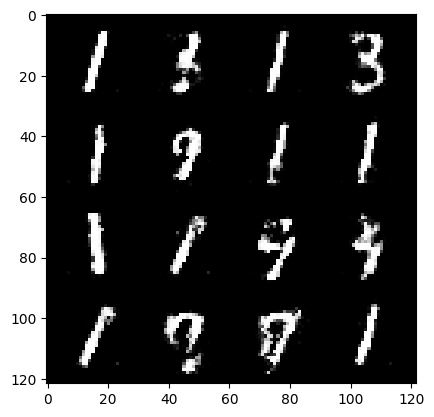

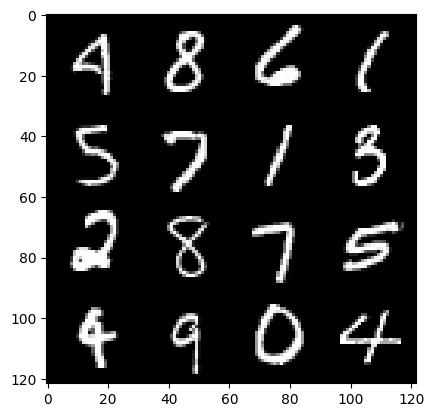

94: step 300 / Gen loss: 3.873956160147985 / Disc loss: 0.3493610648065803


  0%|          | 0/469 [00:00<?, ?it/s]

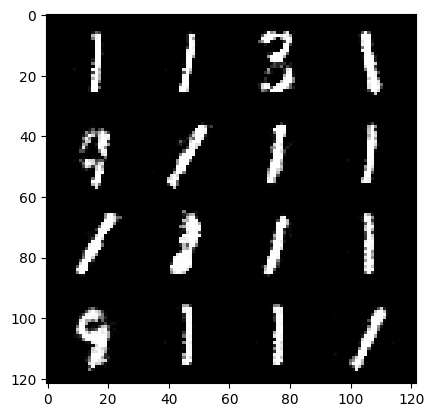

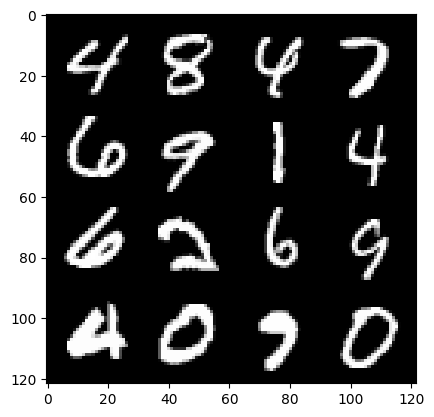

95: step 300 / Gen loss: 3.8437402248382573 / Disc loss: 0.3687065350512663


  0%|          | 0/469 [00:00<?, ?it/s]

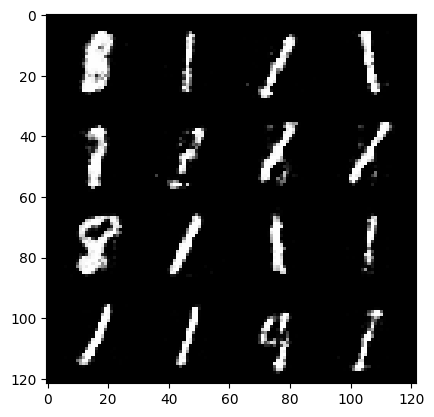

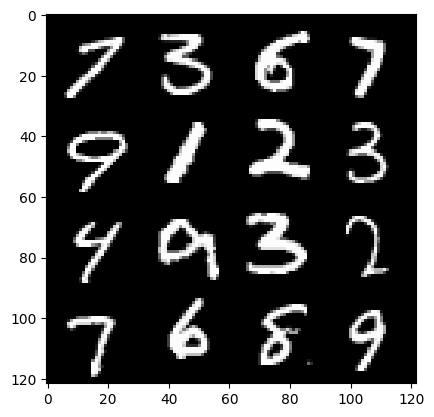

96: step 300 / Gen loss: 3.674323283433912 / Disc loss: 0.3598900498946506


  0%|          | 0/469 [00:00<?, ?it/s]

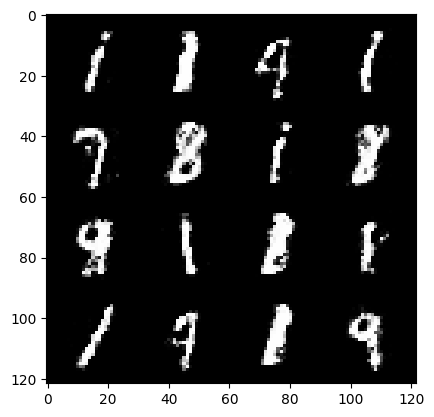

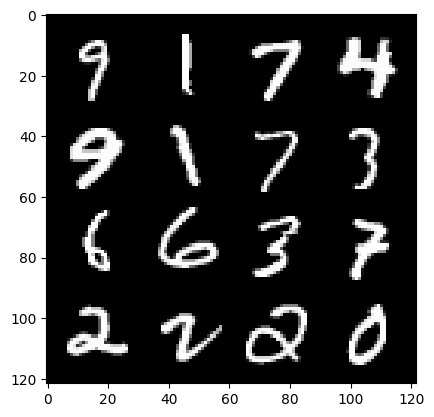

97: step 300 / Gen loss: 3.5745843549569463 / Disc loss: 0.38406437699993506


  0%|          | 0/469 [00:00<?, ?it/s]

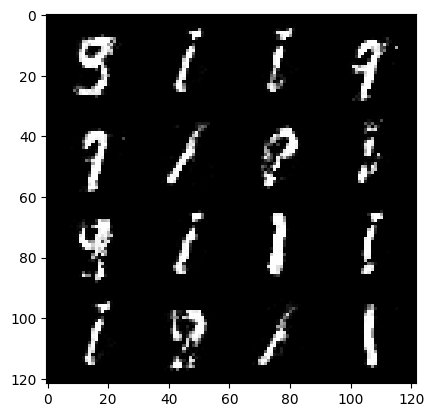

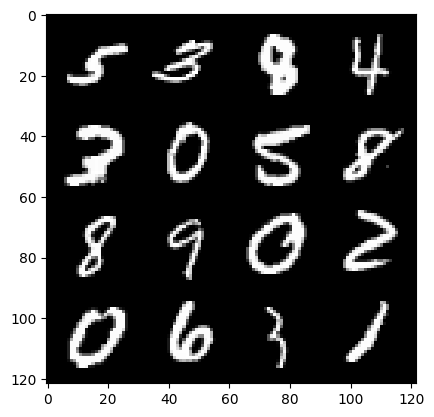

98: step 300 / Gen loss: 3.658714121182757 / Disc loss: 0.3448679419110217


  0%|          | 0/469 [00:00<?, ?it/s]

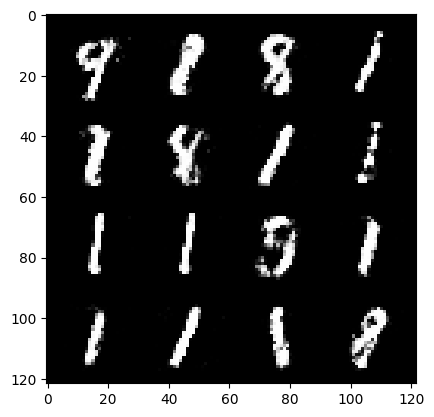

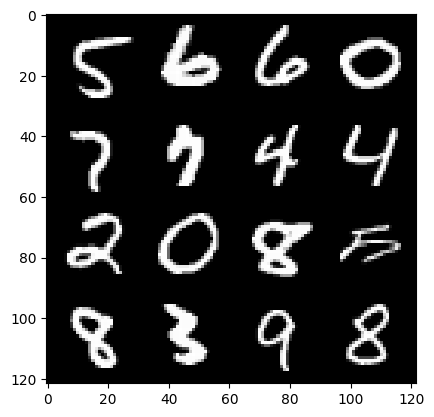

99: step 300 / Gen loss: 3.6630967267354366 / Disc loss: 0.36058406814932853


  0%|          | 0/469 [00:00<?, ?it/s]

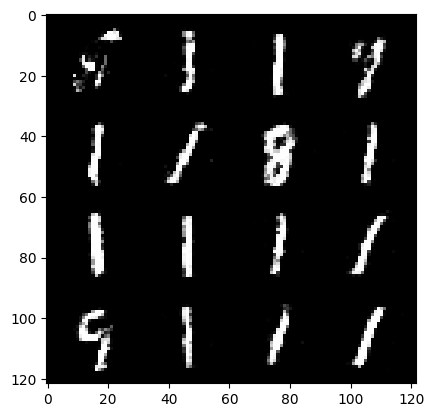

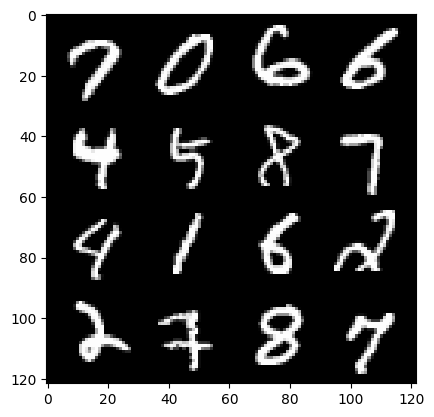

100: step 300 / Gen loss: 3.5490326150258396 / Disc loss: 0.38381372536222175


  0%|          | 0/469 [00:00<?, ?it/s]

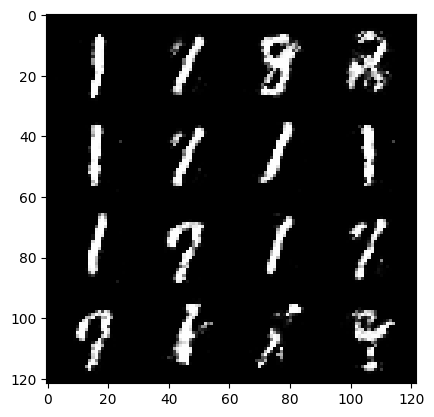

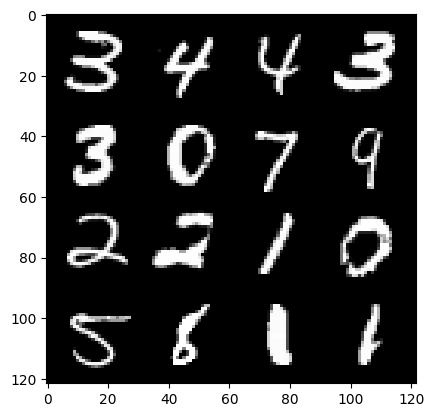

101: step 300 / Gen loss: 3.485305388371149 / Disc loss: 0.4013466430703797


  0%|          | 0/469 [00:00<?, ?it/s]

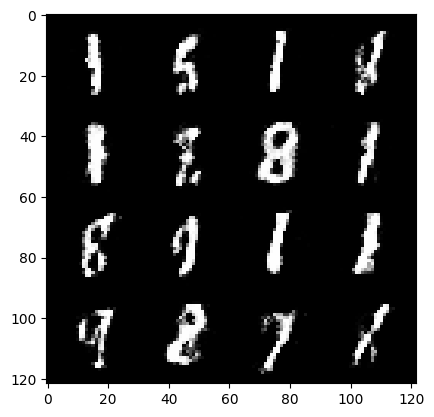

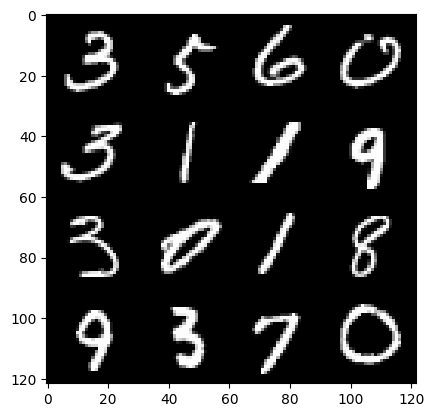

102: step 300 / Gen loss: 3.538327746391297 / Disc loss: 0.39162420178453167


  0%|          | 0/469 [00:00<?, ?it/s]

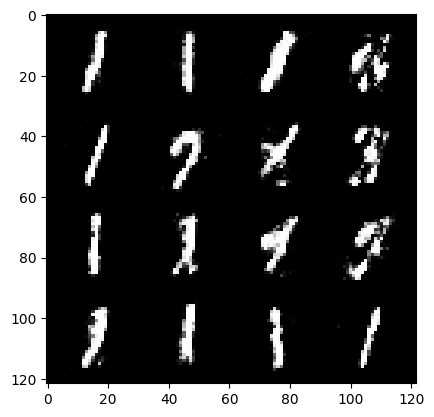

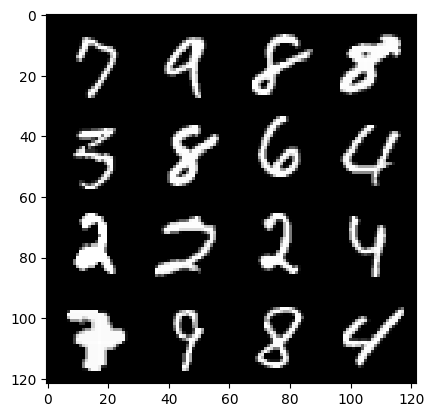

103: step 300 / Gen loss: 3.406129350662233 / Disc loss: 0.4128808468083538


  0%|          | 0/469 [00:00<?, ?it/s]

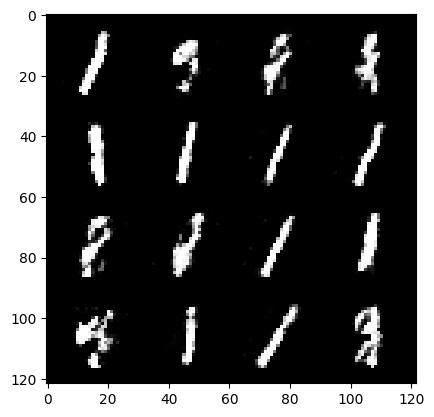

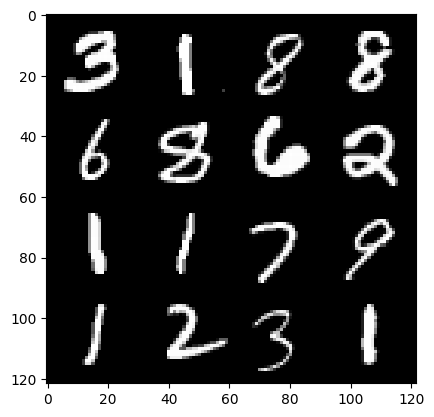

104: step 300 / Gen loss: 3.370284317731858 / Disc loss: 0.4213182193537553


  0%|          | 0/469 [00:00<?, ?it/s]

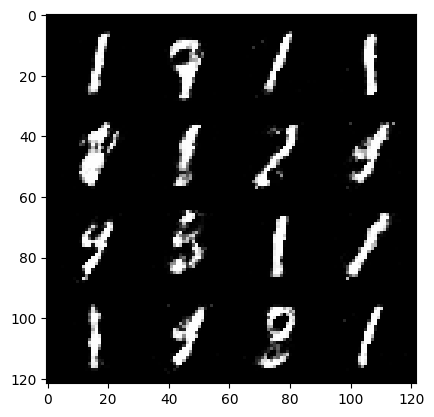

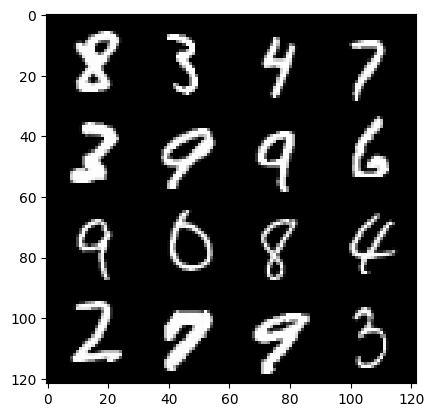

105: step 300 / Gen loss: 3.297486124436061 / Disc loss: 0.4193151006599265


  0%|          | 0/469 [00:00<?, ?it/s]

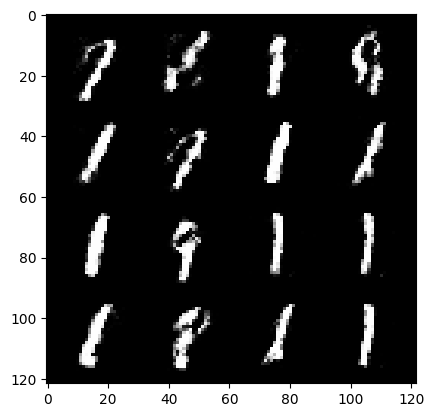

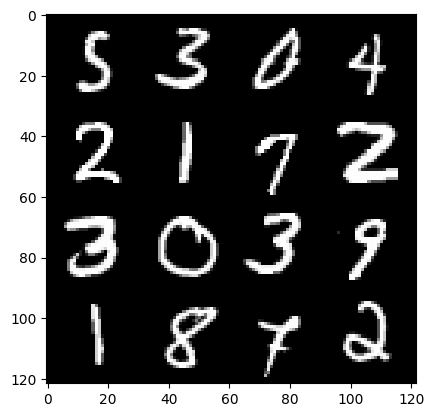

106: step 300 / Gen loss: 3.363631563981378 / Disc loss: 0.42241787170370426


  0%|          | 0/469 [00:00<?, ?it/s]

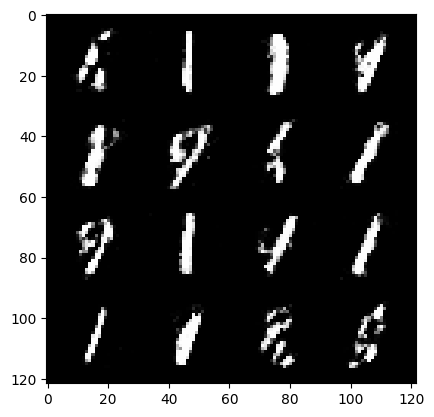

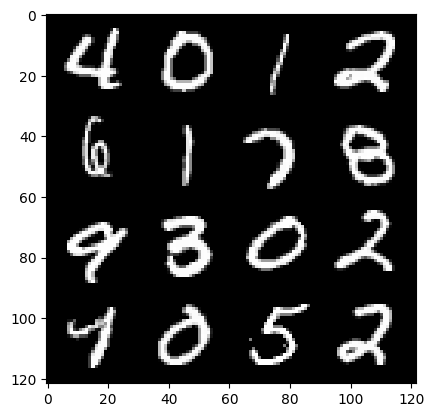

107: step 300 / Gen loss: 3.269140114386876 / Disc loss: 0.4223725045224031


  0%|          | 0/469 [00:00<?, ?it/s]

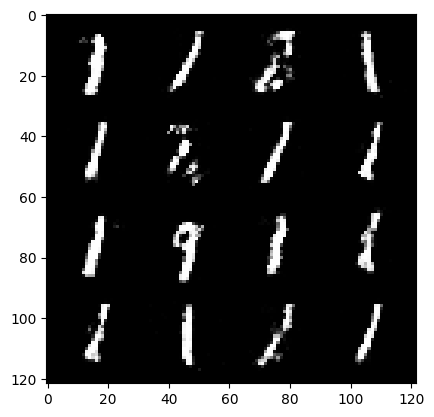

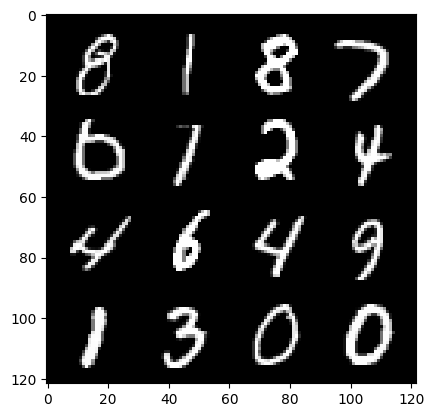

108: step 300 / Gen loss: 3.235908341407773 / Disc loss: 0.4266956291596091


  0%|          | 0/469 [00:00<?, ?it/s]

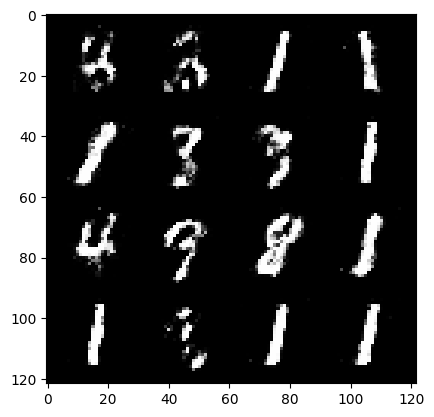

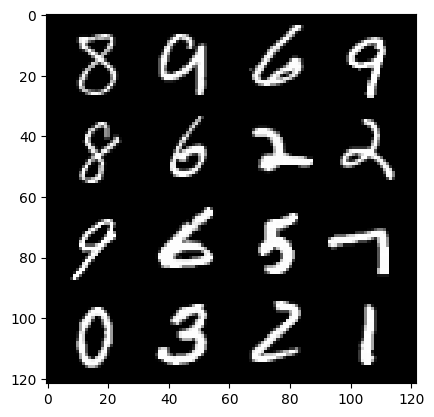

109: step 300 / Gen loss: 3.228218861818314 / Disc loss: 0.43256183231870304


  0%|          | 0/469 [00:00<?, ?it/s]

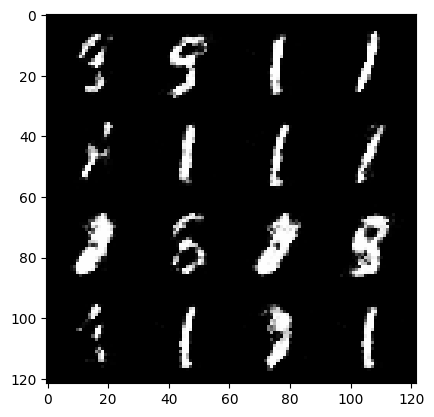

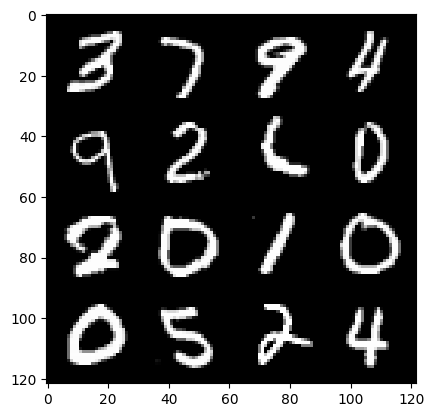

110: step 300 / Gen loss: 3.277903245290126 / Disc loss: 0.41608472704887395


  0%|          | 0/469 [00:00<?, ?it/s]

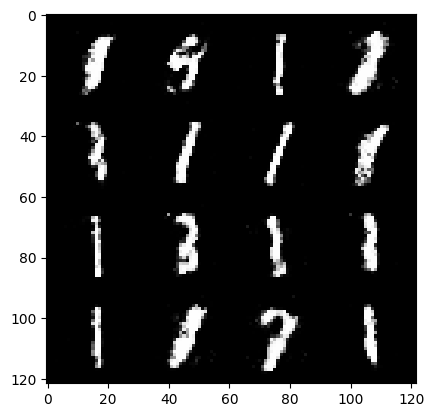

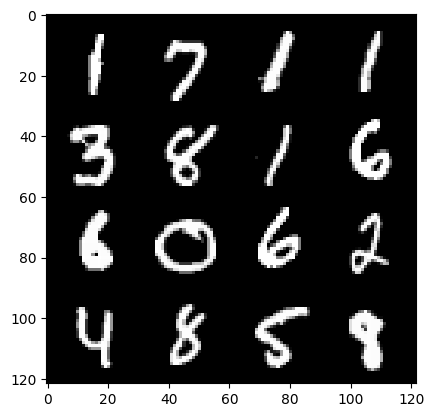

111: step 300 / Gen loss: 3.1796798690160113 / Disc loss: 0.43712272678812336


  0%|          | 0/469 [00:00<?, ?it/s]

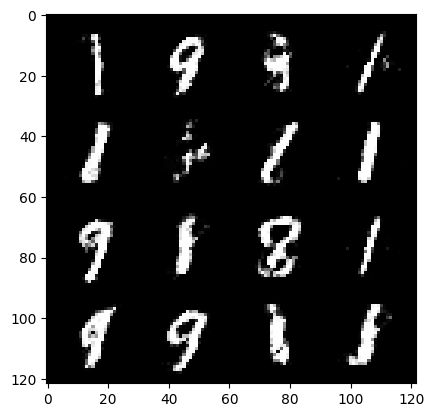

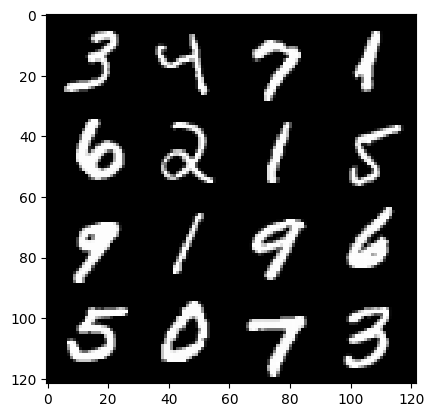

112: step 300 / Gen loss: 3.2154752631982166 / Disc loss: 0.42476536159714096


  0%|          | 0/469 [00:00<?, ?it/s]

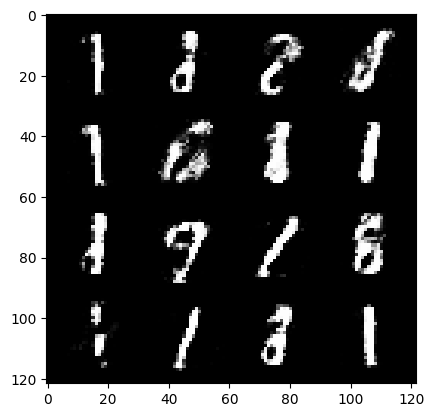

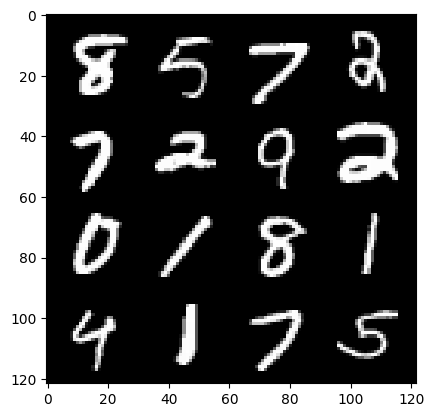

113: step 300 / Gen loss: 3.2427039154370627 / Disc loss: 0.4246107590198516


  0%|          | 0/469 [00:00<?, ?it/s]

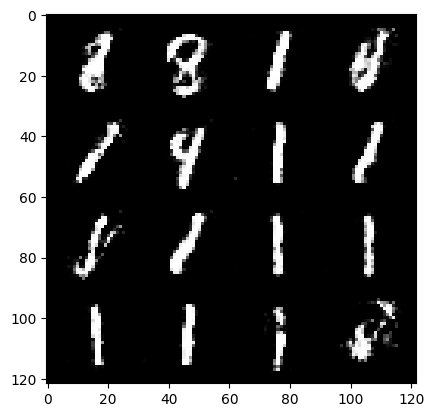

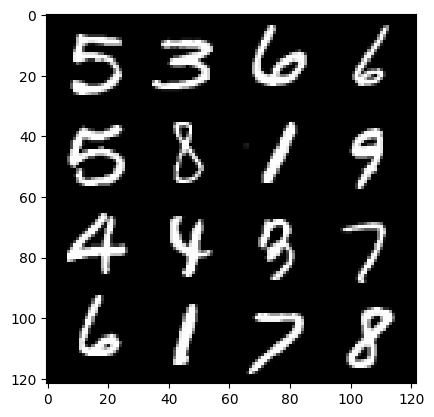

114: step 300 / Gen loss: 3.1632681787014003 / Disc loss: 0.4510020799934866


  0%|          | 0/469 [00:00<?, ?it/s]

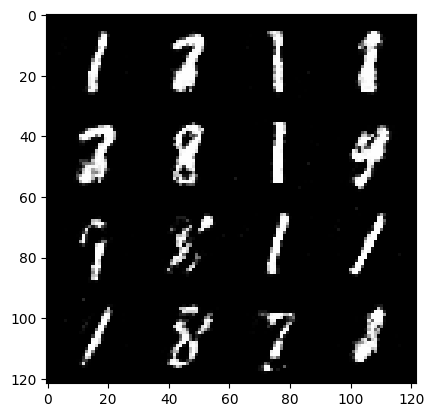

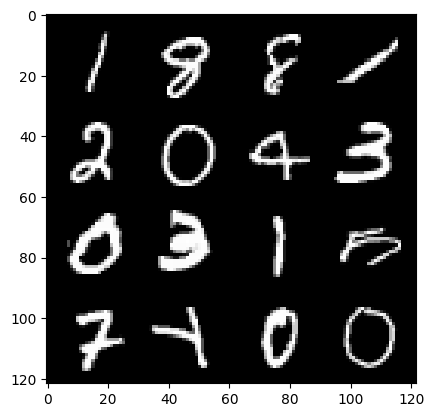

115: step 300 / Gen loss: 3.116980351607003 / Disc loss: 0.4576044262448948


  0%|          | 0/469 [00:00<?, ?it/s]

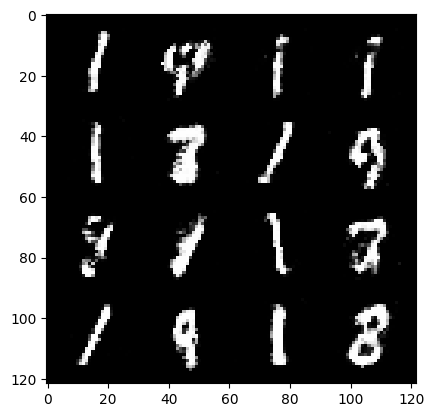

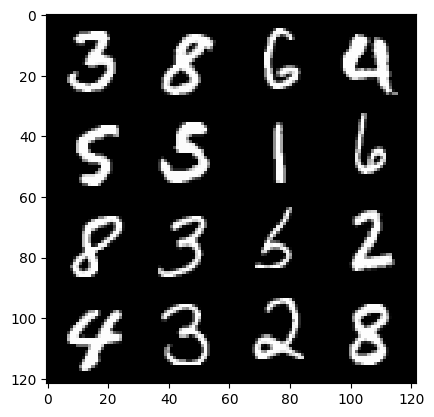

116: step 300 / Gen loss: 3.1355859371026353 / Disc loss: 0.4325952965021135


  0%|          | 0/469 [00:00<?, ?it/s]

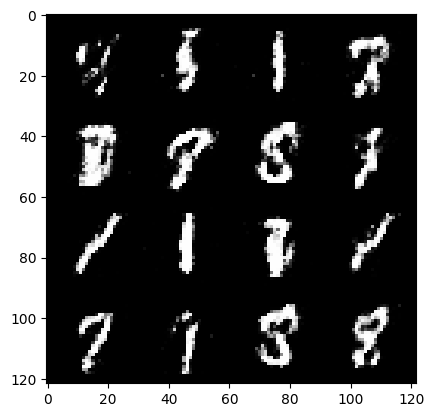

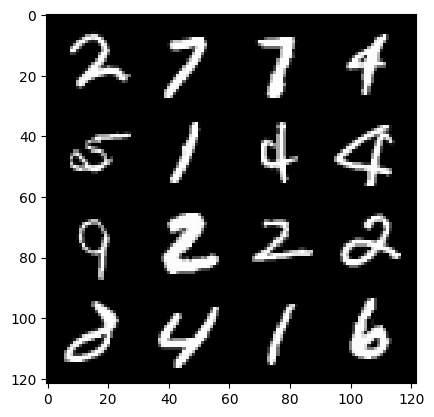

117: step 300 / Gen loss: 3.1309226560592642 / Disc loss: 0.43357344220081967


  0%|          | 0/469 [00:00<?, ?it/s]

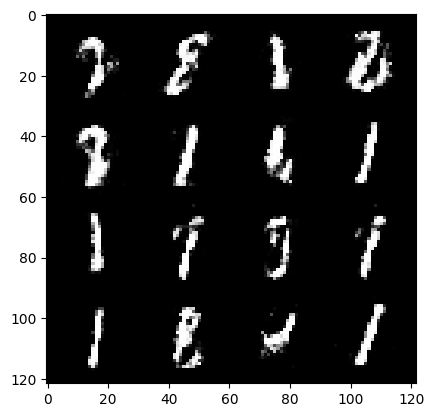

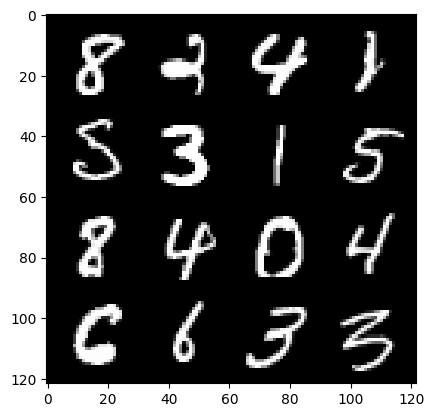

118: step 300 / Gen loss: 3.088677329222357 / Disc loss: 0.4540008076528703


  0%|          | 0/469 [00:00<?, ?it/s]

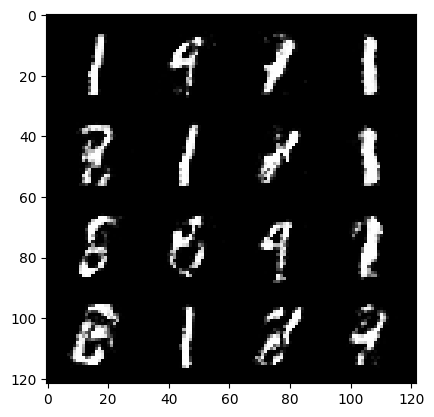

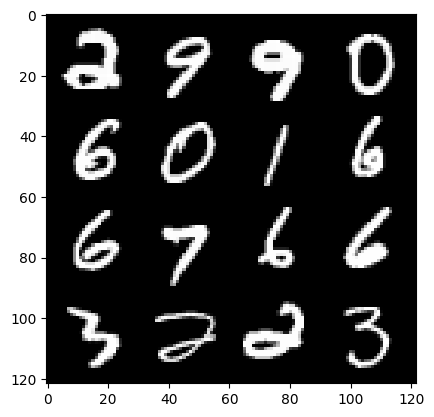

119: step 300 / Gen loss: 3.1793819407622004 / Disc loss: 0.4295060122509795


  0%|          | 0/469 [00:00<?, ?it/s]

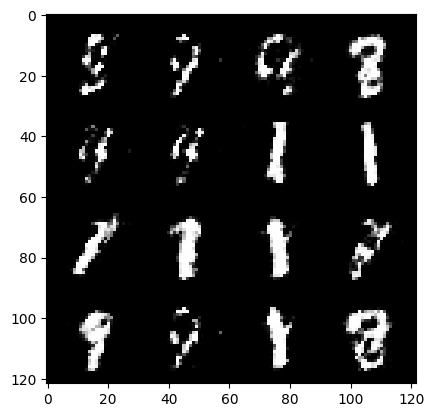

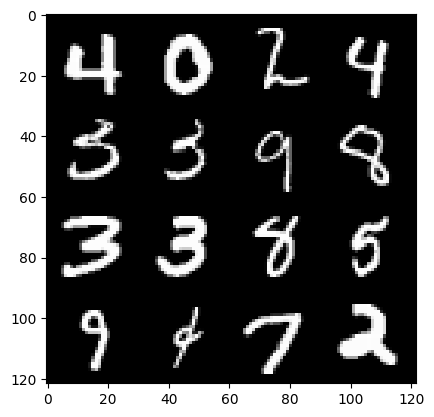

120: step 300 / Gen loss: 3.1749563129742935 / Disc loss: 0.4303821772336964


  0%|          | 0/469 [00:00<?, ?it/s]

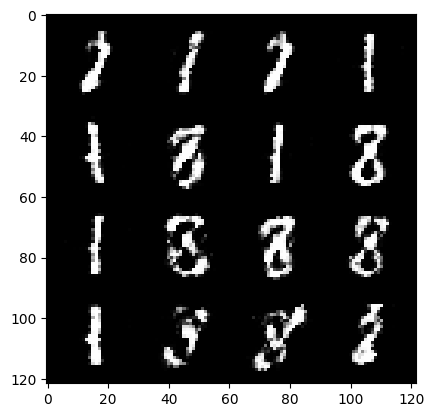

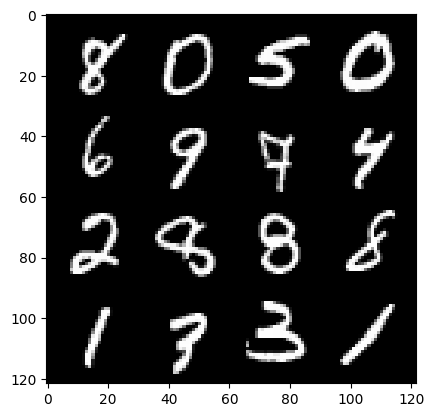

121: step 300 / Gen loss: 3.1102715444564804 / Disc loss: 0.4500662509103619


  0%|          | 0/469 [00:00<?, ?it/s]

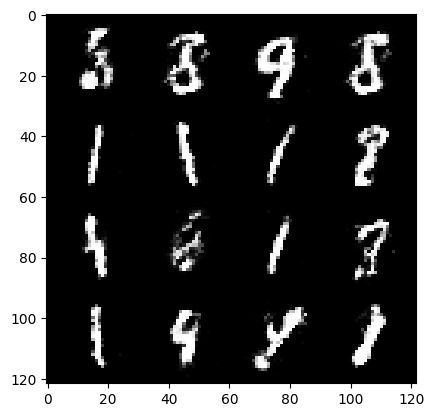

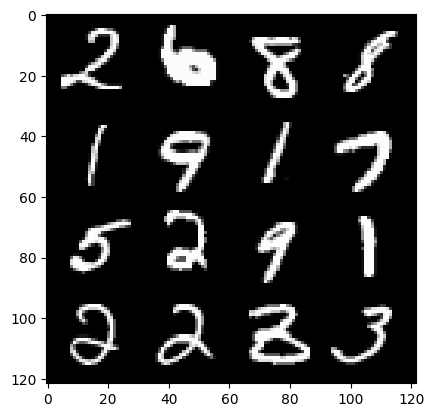

122: step 300 / Gen loss: 3.1245868881543473 / Disc loss: 0.42777293706933633


  0%|          | 0/469 [00:00<?, ?it/s]

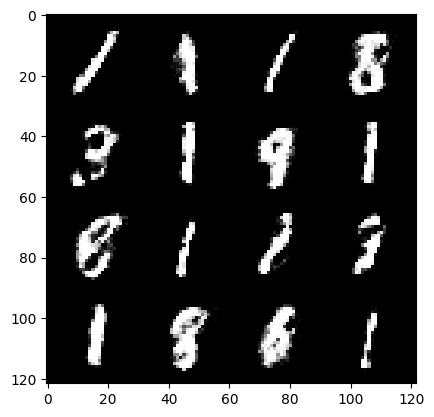

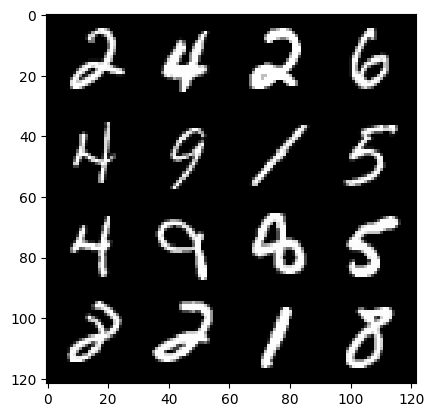

123: step 300 / Gen loss: 3.062466653982799 / Disc loss: 0.46741099183758095


  0%|          | 0/469 [00:00<?, ?it/s]

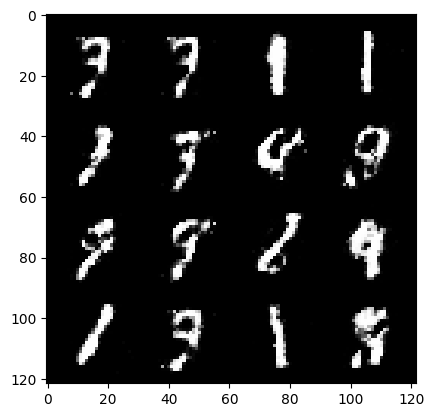

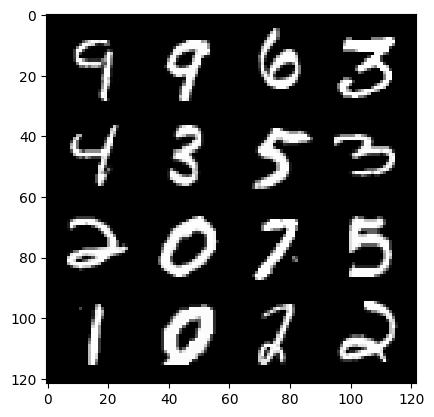

124: step 300 / Gen loss: 3.017421673933665 / Disc loss: 0.46511040518681246


  0%|          | 0/469 [00:00<?, ?it/s]

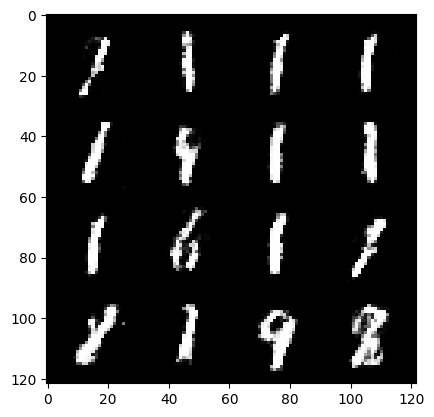

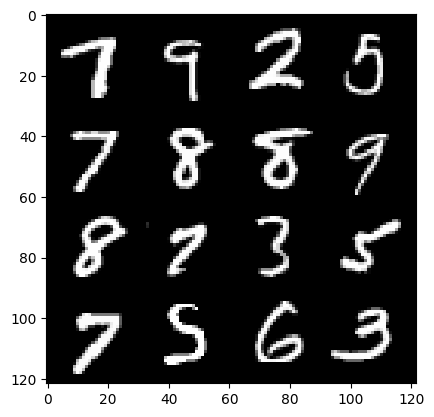

125: step 300 / Gen loss: 2.9768815922737106 / Disc loss: 0.46938611070315045


  0%|          | 0/469 [00:00<?, ?it/s]

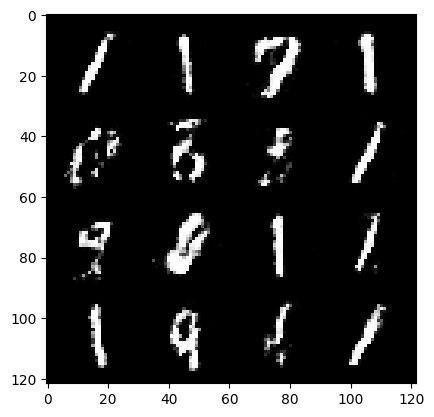

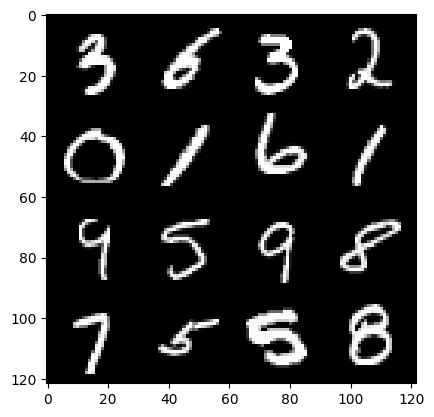

126: step 300 / Gen loss: 3.124213401873907 / Disc loss: 0.44127964521447804


  0%|          | 0/469 [00:00<?, ?it/s]

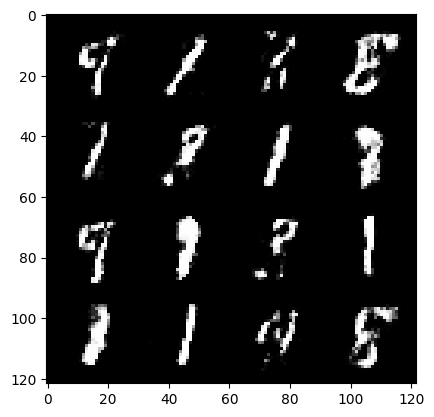

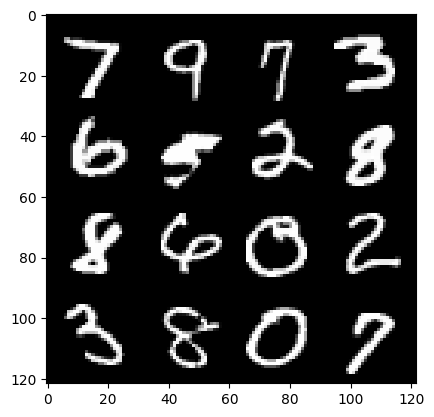

127: step 300 / Gen loss: 2.9195070318381027 / Disc loss: 0.4831326298415662


  0%|          | 0/469 [00:00<?, ?it/s]

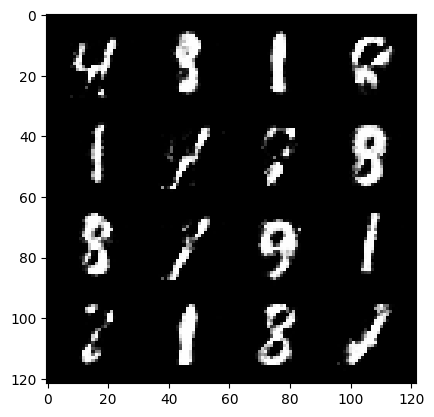

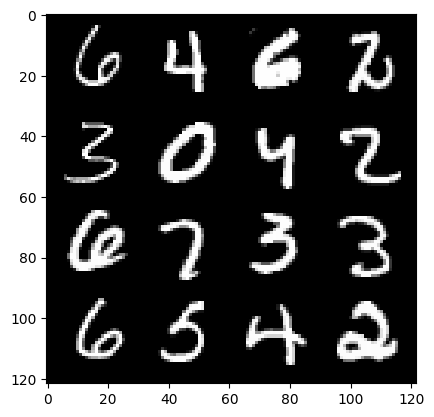

128: step 300 / Gen loss: 2.976639605760574 / Disc loss: 0.47043304006258646


  0%|          | 0/469 [00:00<?, ?it/s]

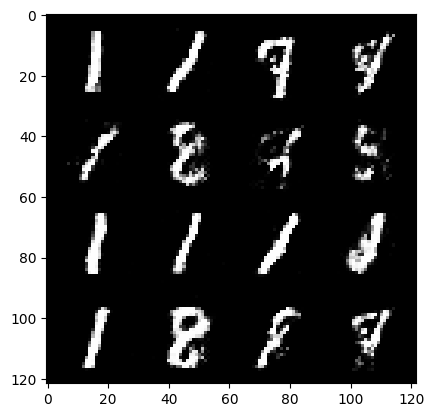

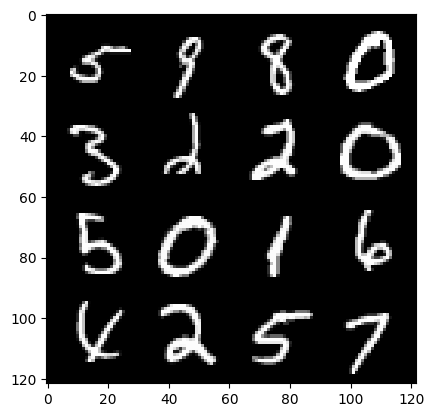

129: step 300 / Gen loss: 2.9929541528224948 / Disc loss: 0.4617811500032739


  0%|          | 0/469 [00:00<?, ?it/s]

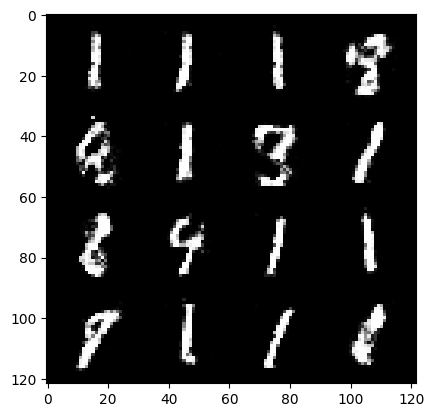

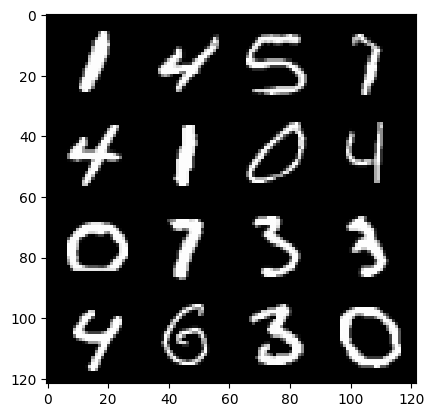

130: step 300 / Gen loss: 2.9238305604457855 / Disc loss: 0.49081614439686155


  0%|          | 0/469 [00:00<?, ?it/s]

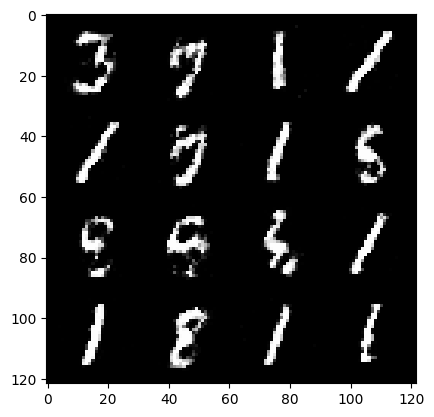

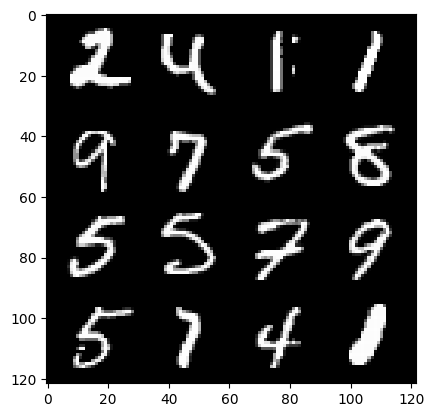

131: step 300 / Gen loss: 3.0003809030850728 / Disc loss: 0.48047624836365355


  0%|          | 0/469 [00:00<?, ?it/s]

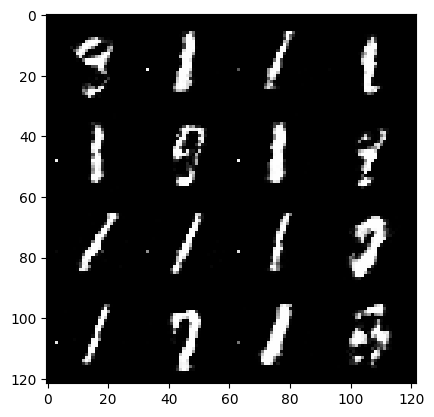

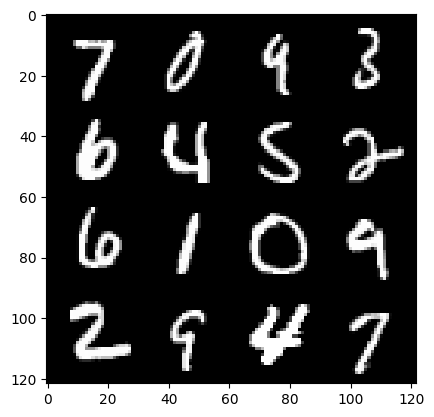

132: step 300 / Gen loss: 2.886260757843654 / Disc loss: 0.48336333115895613


  0%|          | 0/469 [00:00<?, ?it/s]

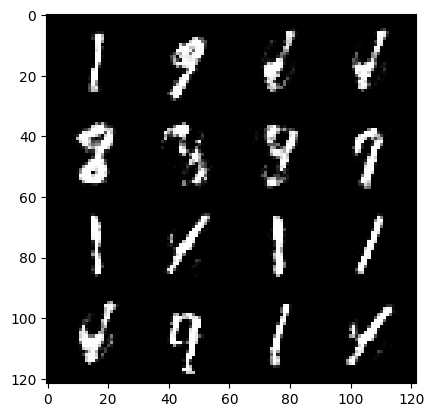

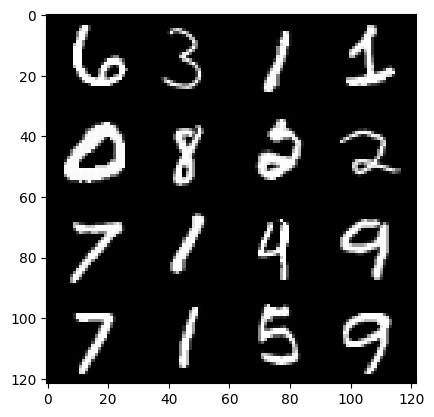

133: step 300 / Gen loss: 2.9453255244096135 / Disc loss: 0.4826556166013084


  0%|          | 0/469 [00:00<?, ?it/s]

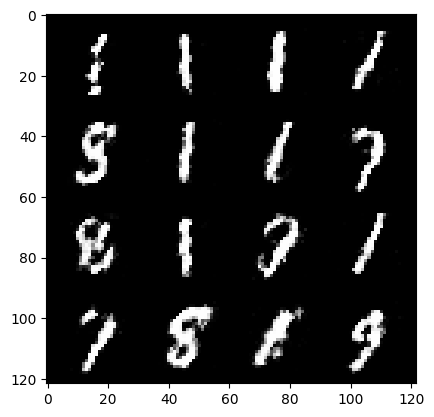

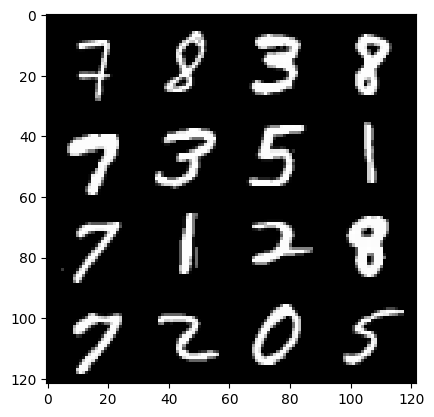

134: step 300 / Gen loss: 2.9316721705595676 / Disc loss: 0.4718847783903277


  0%|          | 0/469 [00:00<?, ?it/s]

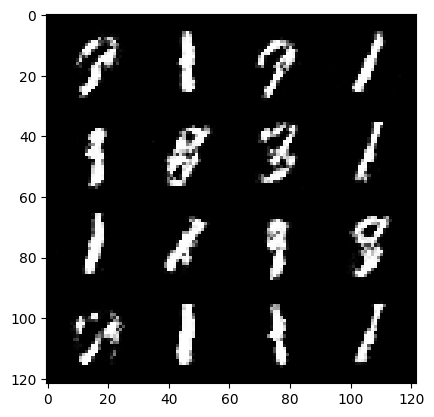

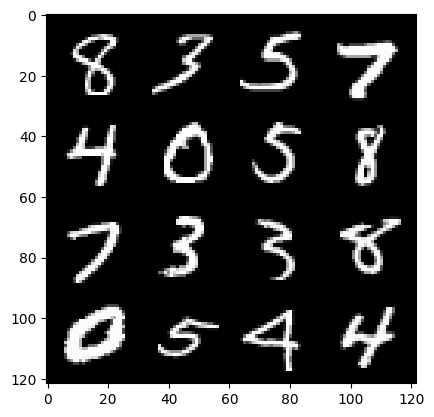

135: step 300 / Gen loss: 2.893284729321797 / Disc loss: 0.48485850666960034


  0%|          | 0/469 [00:00<?, ?it/s]

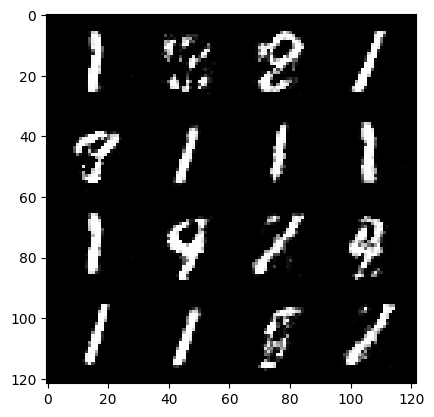

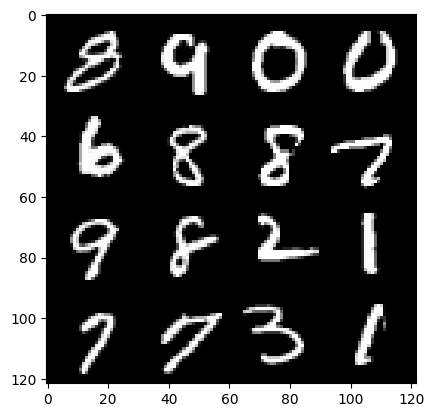

136: step 300 / Gen loss: 2.922006217638654 / Disc loss: 0.48867749904592855


  0%|          | 0/469 [00:00<?, ?it/s]

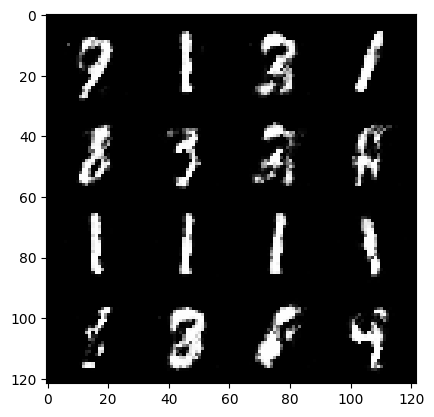

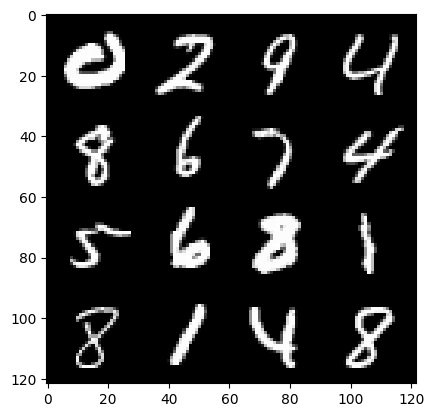

137: step 300 / Gen loss: 2.873137449026106 / Disc loss: 0.4872212169567745


  0%|          | 0/469 [00:00<?, ?it/s]

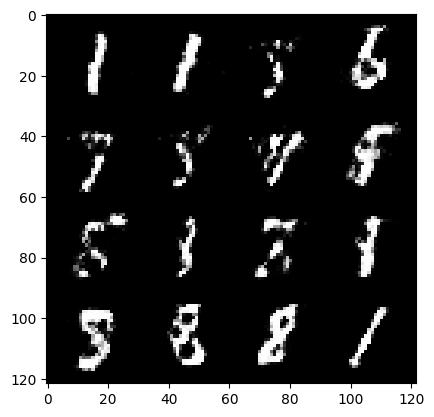

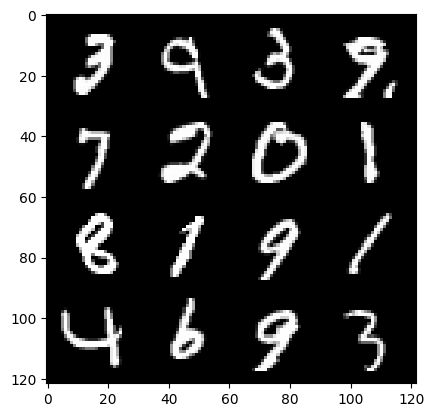

138: step 300 / Gen loss: 2.862562612692516 / Disc loss: 0.4800861103832722


  0%|          | 0/469 [00:00<?, ?it/s]

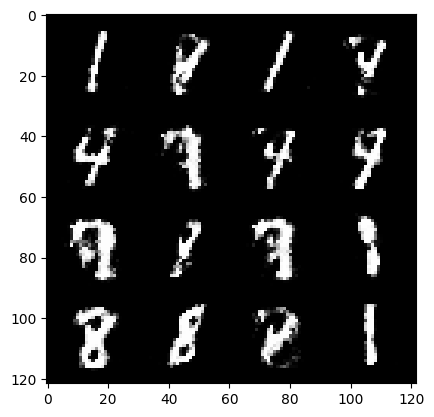

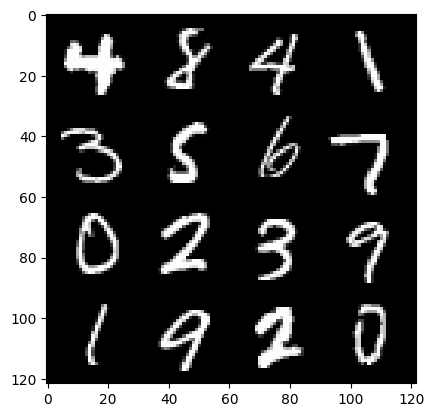

139: step 300 / Gen loss: 2.8445944913228356 / Disc loss: 0.4891301616032916


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# 60000 / 128 = 468.75 = 469 steps in each epoch
# Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
    cur_step = 0
    for real, _ in tqdm(dataloader): # we use _ since we do not need labels in GAN
        # discriminator
        disc_opt.zero_grad()

        cur_bs = len(real) # real (except last time) = 128 x 1 x 28 x 28
        real = real.view(cur_bs, -1) # 128 x 784
        real = real.to(device) # store images on the GPU

        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real, z_dim)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # generator
        gen_opt.zero_grad()
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # visualization & stats
        mean_disc_loss += disc_loss.item()/info_step # item() translates tensor value to an individual value
        mean_gen_loss += gen_loss.item()/info_step

        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise(cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake)
            show(real)
            print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / Disc loss: {mean_disc_loss}")
            mean_gen_loss, mean_disc_loss = 0, 0

        cur_step += 1